# Numerical Linear Algebra
The term **Numerical Linear Algebra** refers to the use of matrices to solve computational science problems.  In this chapter we start by learning how to construct these objects effectively in `python`.  We make an emphasis on importing large sparse matrices from repositories online.  We then proceed to reviewing basic manipulation and operations on them.  The next step is a study of the different matrix functions implemented in `scipy`.  We continue on to exploring different factorizations for the solution of matrix equations, and for the computation of eigenvalues and their corresponding eigenvectors.

## Motivation

The following diagram shows a graph that represents a series of web pages (numbered from 1 to 8).

<img src="4749_01_01.png" style="text-align:center; width:50%">

An arrow from a node to another indicates the existence of a link from the web page represented by the sending node, to the page represented by the receiving node.  For example, the arrow from node 2 to node 1 indicates that there is a link in web page 2 pointing to web page 1.  Notice how web page 4 has two outer links (to pages 2 and 8), and there are three pages that link to web page 4 (pages 2, 6 and 7).  The pages represented by nodes 2, 4 and 8 seem to be the most *popular* at first sight.

Is there a mathematical way to actually express the popularity of a web page within a network?  Researchers at Google came up with the idea of a **PageRank** to roughly estimate this concept by counting the number and quality of links to a page.  It goes like this:

We construct a _transition matrix_ of this graph $T=a_{i,j}$ in the following fashion: the entry $a_{i,j}$ is $1/k$ if there is a link from web page $i$ to web page $j$, and the total number of outer links in web page $i$ amounts to $k$.  Otherwise, the entry is just zero.   The size of a transition matrix of $N$ web pages is always $N \times N$. In our case, the matrix has size $8 \times 8$:

$$\begin{pmatrix}
0  &1/2  & 0   & 0    & 0   & 0   & 0   & 0 \\
1  & 0   &1/2  &1/2   & 0   & 0   & 0   & 0 \\
0  & 0   & 0   & 0    & 0   & 0   &1/3  & 0 \\
0  &1/2  & 0   & 0    & 0   & 1   &1/3  & 0 \\
0  & 0   &1/2  & 0    & 0   & 0   & 0   & 0 \\
0  & 0   & 0   & 0    & 0   & 0   & 0   &1/2\\
0  & 0   & 0   & 0    &1/2  & 0   & 0   &1/2\\
0  & 0   & 0   &1/2   &1/2  & 0   &1/3  &0
\end{pmatrix}$$ 

Let us open an `ipython` session and load this particular matrix to memory.
Remember that in `python`, indices start from zero, not one:

In [1]:
import numpy as np, matplotlib.pyplot as plt, scipy.linalg as spla, scipy.sparse as spsp, scipy.sparse.linalg as spspla

np.set_printoptions(suppress=True, precision=3)

cols = np.array([0,1,1,2,2,3,3,4,4,5,6,6,6,7,7])
rows = np.array([1,0,3,1,4,1,7,6,7,3,2,3,7,5,6])
data = np.array([1., 0.5, 0.5, 0.5, 0.5, 
                 0.5, 0.5, 0.5, 0.5, 1., 
                 1./3, 1./3, 1./3, 0.5, 0.5])

T = np.zeros((8,8))
T[rows,cols] = data

From the transition matrix, we create a _Page Rank matrix_, $G$ (also known as the **Google matrix**), by fixing a positive constant $0 < p \leq 1$, and following the formula $G = (1-p) \cdot T + p \cdot B$.  Here, $B$ is a matrix with the same size as $T$, with all its entries equal to $1/N$.  For example, if we choose $p=0.15$, we obtain the following Google matrix

In [2]:
G = (1-0.15) * T + 0.15/8
print G

[[ 0.019  0.444  0.019  0.019  0.019  0.019  0.019  0.019]
 [ 0.869  0.019  0.444  0.444  0.019  0.019  0.019  0.019]
 [ 0.019  0.019  0.019  0.019  0.019  0.019  0.302  0.019]
 [ 0.019  0.444  0.019  0.019  0.019  0.869  0.302  0.019]
 [ 0.019  0.019  0.444  0.019  0.019  0.019  0.019  0.019]
 [ 0.019  0.019  0.019  0.019  0.019  0.019  0.019  0.444]
 [ 0.019  0.019  0.019  0.019  0.444  0.019  0.019  0.444]
 [ 0.019  0.019  0.019  0.444  0.444  0.019  0.302  0.019]]


Google matrices have some interesting properties:
* 1 is an eigenvalue of multiplicity one.
* 1 is actually the largest eigenvalue: all the other eigenvalues are in modulus smaller than 1.
* The eigenvector corresponding to eigenvalue 1 has all entries positive.  In particular, for the eigenvalue 1 there exists a unique eigenvector with the sum of its entries equal to one.  This is what we call the **Page Rank vector**.

A quick computation with `scipy.linalg.eig` finds that eigenvector for us:

In [3]:
eigenvalues, eigenvectors = spla.eig(G)
print eigenvalues

[ 1.000+0.j    -0.655+0.j    -0.333+0.313j -0.333-0.313j -0.171+0.372j
 -0.171-0.372j  0.544+0.j     0.268+0.j   ]


In [4]:
PageRank = eigenvectors[:,0]
PageRank /= sum(PageRank)

print PageRank.real

[ 0.117  0.232  0.048  0.219  0.039  0.086  0.102  0.157]


Those values correspond to the Page Ranks of each of the eight web pages depicted on the graph.  As expected, the maximum value of those is associated to the second web page (0.232), closely followed by the fourth (0.219), and then the eighth web page (0.157).

> Note how this problem of networks of web pages has been translated into mathematical objects, to an equivalent problem involving matrices, eigenvalues and eigenvectors, and has been solved with techniques of Linear Algebra.

The transition matrix is **sparse**: most of its entries are zeros.  Sparse matrices with extremely large size are of special importance in *Numerical Linear Algebra*, not only because they encode challenging scientific problems, but also because it is extremely hard to manipulate them with basic algorithms. 

Rather than storing to memory all values in the matrix, it makes sense to collect only the non-zero values instead, and use algorithms with exploit these smart storage schemes.  The gain in memory management is obvious.  These methods are usually faster for this kind of matrices and give less roundoff errors, since there are usually far less operations involved.  This is another advantage of `scipy`, since it contains numerous procedures to attack different problems where data is stored in this fashion.  Let us observe its power with another example:

The **University of Florida Sparse Matrix Collection** is the largest database of matrices accessible online.  As of January 2014, it contains 157 groups of matrices arising from all sorts of scientific disciplines.  The sizes of the matrices range from very small (1-by-2) to insanely large (28-million-by-28-million).  More matrices are expected to be added constantly, as they arise in different engineering problems.

>More information about this database can be found in ACM Transactions on Mathematical Software, vol 38, Issue 1, 2011, pp 1:1 - 1:25, by T.A. Davis and Y.Hu, or online at  [www.cise.ufl.edu/research/sparse/matrices](www.cise.ufl.edu/research/sparse/matrices)

For example, the group with the most matrices in the database is the original Harwell-Boeing Collection, with 292 different sparse matrices.  This group can also be accessed online at the **Matrix Market**: [math.nist.gov/MatrixMarket](math.nist.gov/MatrixMarket)

Each matrix in the database comes in three formats: 
* **Matrix Market Exchange Format** [Boisvert et al. 1997] 
* **Rutherford-Boeing Exchange Format** [Duff et al. 1997]
* Proprietary **matlab** `.mat` format.

Let us import to our `ipython` session two matrices in Matrix Market Exchange format from the Collection, meant to be used in a solution of a least squares problem.  These matrices are located at 

[www.cise.ufl.edu/research/sparse/matrices/Bydder/mri2.html](www.cise.ufl.edu/research/sparse/matrices/Bydder/mri2.html)

We download the corresponding `tar` bundle and `untar` it to get two `ASCII` files:
* `mri2.mtx` (the main matrix in the least squares problem)
* `mri2_b.mtx` (the right-hand side of the equation)

The first twenty lines of the file mri2.mtx read as follows:

    %% MatrixMarket matrix coordinate real general
    %-----------------------------------------------------------------
    % UF Sparse Matrix Collection, Tim Davis
    % http://www.cise.ufl.edu/research/sparse/matrices/Bydder/mri2
    % name: Bydder/mri2
    % [MRI reconstruction (2), from Mark Bydder, UCSD]
    % id: 1318
    % date: 2005
    % author: M. Bydder
    % ed: T. Davis
    % fields: title A name b id notes date author ed kind
    % kind: computer graphics/vision problem
    %-----------------------------------------------------------------
    % notes:
    % x=lsqr(A,b); imagesc(abs(fftshift(fft2(reshape(x,384,384)))));
    %-----------------------------------------------------------------
    63240 147456 569160
    31992 1720 .053336731395584265
    31992 1721 .15785917688901102
    31992 1722 .07903055194318191
    
The first sixteen lines are comments, and give us some information about the generation of the matrix. 
* The computer vision problem where it arose:  An MRI reconstruction.
* Author information: Mark Bydder, UCSD.
* Procedures to apply to the data: Solve a least square problem $A \cdot x - b$, and posterior visualization of the result.

The seventeenth line indicates the size of the matrix: 63240 rows by 147456 columns, as well as the number of non-zero entries in the data: 569160.

The rest of the file includes precisely 569160 lines, each containing two integer numbers, and a floating point number: These are the locations of the non-zero elements in the matrix, together with the corresponding values.

> We need to take into account that these files use the `Fortran` convention of starting arrays from 1, not from 0.  See `In [13]`.

A good way to read this file into an ndarray is by means of the function `loadtxt` in `numpy`.  We can then use `scipy` to transform the array into a sparse matrix with the function `coo_matrix` in the module `scipy.sparse` (`coo` stands for *coordinate* internal format).

In [5]:
rows, cols, data = np.loadtxt("mri2.mtx", skiprows=17, unpack=True)
rows -= 1 
cols -= 1;

MRI2 = spsp.coo_matrix((data, (rows, cols)), shape=(63240,147456))

The best way to visualize the sparsity of this matrix is by means of the routine `spy` from the module `matplotlib.pyplot`.

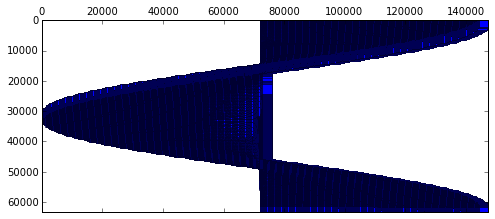

In [6]:
%matplotlib inline

plt.figure(figsize=(8,8))
plt.spy(MRI2)
plt.show()

These are the first ten lines from the second file, `mri2_b.mtx`, which does not represent a sparse matrix, but a column vector:

In [7]:
!head mri2_b.mtx

%%MatrixMarket matrix array complex general
%-------------------------------------------------------------------------------
% UF Sparse Matrix Collection, Tim Davis
% http://www.cise.ufl.edu/research/sparse/matrices/Bydder/mri2
% name: Bydder/mri2 : b matrix
%-------------------------------------------------------------------------------
63240 1
-.07214859127998352 .037707749754190445
-.0729086771607399 .03763720765709877
-.07373382151126862 .03766685724258423


Those are six commented lines with information, one more line indicating the shape of the vector (63240 rows and one column), and the rest of the lines contain two columns of floating point values: the real and imaginary parts of the corresponding data. We proceed to read this vector to memory, solve the least squares problem suggested, and obtain the following reconstruction:

CPU times: user 4min 55s, sys: 1min 57s, total: 6min 52s
Wall time: 6min 53s


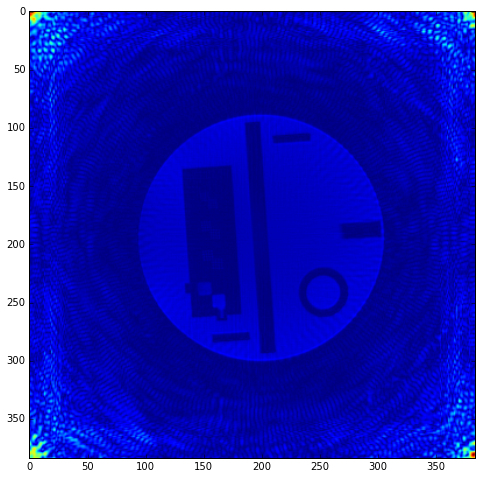

In [8]:
r_vals, i_vals = np.loadtxt("mri2_b.mtx", skiprows=7, unpack=True)

%time solution = spspla.lsqr(MRI2, r_vals + 1j*i_vals)

from scipy.fftpack import fft2, fftshift

img = solution[0].reshape(384,384)
img = np.abs(fftshift(fft2(img)))

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

>If interested in the theory behind the creation of this matrix and the particulars of this problem, read the article _On the optimality of the Gridding Reconstruction Algorithm_, by H. Sedarat and D. G. Nishimura, published in IEEE Trans. Medical Imaging, vol 19, no 4, pp. 306-317, 2000.

For matrices with a good structure, which are going to be exclusively involved in matrix multiplications, it is often possible to store the objects without allocating almost any space. Consider the following example:

A horizontal earthquake oscillation affects each floor of a tall building, depending on the natural frequencies of oscillation of the floors.  If we make certain assumptions, a model to quantize the oscillations on buildings with N floors can be obtained as a second-order system of N differential equations by *competition*: the Newton's second law force is set equal to the sum of Hooke's forces, and the external force due to the earthquake wave.

These are the assumptions we need:
* Each floor is considered a point of mass located at its center-of-mass.  The floors have masses $m[1], m[2], ..., m[N]$.
* Each floor is restored to its equilibrium position by a linear restoring force (Hooke's $-k \times \text{elongation}$).  The Hooke's constants for the floors are $k[1], k[2], ..., k[N]$.
* The locations of masses representing the oscillation of the floors are $x[1], x[2], ..., x[N]$. We assume all of them functions of time, and that at equilibrium they are all equal to zero.
* For simplicity of exposition, we are going to assume no friction: all damping effects on the floors are ignored.
* The equations of a floor depend only on the neighboring floors. 

Set $M$, the mass matrix, to be a diagonal matrix containing the floor masses on its diagonal.  Set $K$, the Hooke's matrix, to be a tri-diagonal matrix with the following structure: for each row $j$, all the entries are zero except 
* Column $j-1$, which we set to be $k[j+1]$, 
* Column $j$, which we set to $-k[j+1]-k[j+1]$, and
* Column $j+1$, which we set to $k[j+2]$.

Set $H$ to be a column vector containing the external force on each floor due to the earthquake, and $X$ the column vector containing the functions $x[j]$.

We have then the system $M \cdot X'' = K \cdot X + H$.  The Homogeneous part of this system is the product of the inverse of $M$ with $K$, which we denote $A$.

To solve the homogeneous linear second-order system $X'' = A \cdot X$, we define the variable $Y$ to contain $2N$ entries: all $N$ functions $x[j]$, followed by their derivatives $x'[j]$.  Any solution of this second-order linear system has a corresponding solution on the first-order linear system $Y' = C \cdot Y$, where $C$ is a block matrix of size $2N \times 2N$.  This matrix $C$ is composed by a block of size $N \times N$ containing only zeros, followed horizontally by the identity (of size $N \times N$), and below these two, the matrix $A$ followed horizontally by another $N \times N$ block of zeros.

It is not necessary to store this matrix $C$ into memory, or any of its factors or blocks.  Instead, we will make use of its structure, and use a **Linear Operator** to represent it.  Minimal data is then needed to generate this operator (only the values of the masses and the Hooke's coefficients): much less than any matrix representation of it.

Let us show a concrete example with 6 floors.  We indicate first their masses and Hooke's constants, and proceed to construct a representation of $A$ as a linear operator:

In [9]:
m = np.array([56., 56., 56., 54., 54., 53.])
k = np.array([561., 562., 560., 541., 542., 530.])

def Axv(v):
    global k, m
    w = v.copy()
    w[0] = (k[1]*v[1] - (k[0]+k[1])*v[0])/m[0]
    for j in range(1, len(v)-1):
        w[j] = k[j]*v[j-1] + k[j+1]*v[j+1] - (k[j]+k[j+1])*v[j]
        w[j] /= m[j]
        w[-1] = k[-1]*(v[-2]-v[-1])/m[-1]
    return w

A = spspla.LinearOperator((6,6), matvec=Axv, matmat=Axv, dtype=np.float64)

The construction of $C$ is very simple now (much simpler than its matrix!):

In [10]:
def Cxv(v):
    n = len(v)/2
    w = v.copy()
    w[:n] = v[n:]
    w[n:] = A * v[:n]
    return w

C = spspla.LinearOperator((12,12), matvec=Cxv, matmat=Cxv, dtype=np.float64)

A solution of this homogeneous system comes in the form of an *action of the exponential* of $C$:  $Y(t) = \operatorname{expm}(C t) \cdot Y(0)$, where $\operatorname{expm}()$ here denotes a matrix exponential function. In `scipy`, this operation is performed with the routine `expm_multiply` in the module `scipy.sparse.linalg`.

For example, in our case, given the initial value containing the values $x[1](0)=0, \dots, x[N](0)=0, x'[1](0)=1, \dots, x'[N](0)=1$, if we require a solution $Y(t)$ for values of $t$ between 0 and 1 in steps of size 0.1, we could issue the following:

>It has been reported in some installations that, in the next step, a matrix for $C$ must be given instead of the actual linear operator (thus contradicting the manual).   If this is the case in your system, simply change $C$ in the next lines, to its matrix representation.

In [11]:
initial_condition = np.zeros(12)
initial_condition[6:] = 1

Y = spspla.expm_multiply(C.matmat(np.eye(12)), np.ones(12), start=0, stop=1, num=10)

The oscillations of the six floors during the first second can then be calculated and plotted as follows.

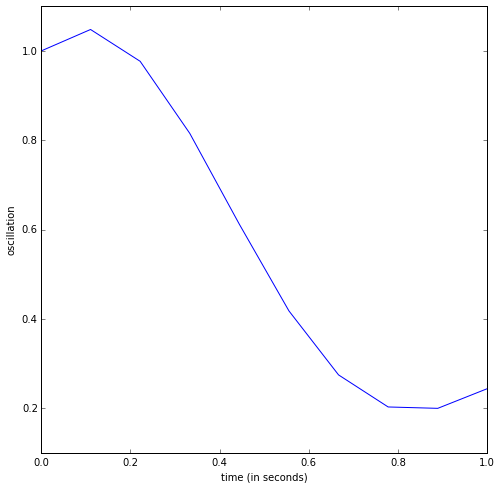

In [12]:
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,10), Y[:,0])
plt.xlabel('time (in seconds)')
plt.ylabel('oscillation')
plt.show()

>For more details about systems of differential equations, and how to solve them with actions of exponentials, read for example the excellent book _Elementary Differential Equations_ 10 ed., by William E. Boyce and Richard C. DiPrima. Wiley, 2012.

These three examples illustrate the goal of this first chapter: **Numerical Linear Algebra**.  In `python` this is accomplished first by storing the data in matrix form, or as a related linear operator, by means of any of the following classes:
* `numpy.ndarray` (making sure that they are two-dimensional)
* `numpy.matrix`
* `scipy.sparse.bsr_matrix` (Block Sparse Row matrix)
* `scipy.sparse.coo_matrix` (Sparse Matrix in **COO**rdinate format)
* `scipy.sparse.csc_matrix` (Compressed Sparse Column matrix)
* `scipy.sparse.csr_matrix` (Compressed Sparse Row matrix)
* `scipy.sparse.dia_matrix` (Sparse matrix with **DIA**gonal storage)
* `scipy.sparse.dok_matrix` (Sparse matrix based on a Dictionary of Keys)
* `scipy.sparse.lil_matrix` (Sparse matrix based on a linked list)
* `scipy.sparse.linalg.LinearOperator`

As we have seen in the examples, the choice of different classes obeys mainly to the sparsity of the data, and the algorithms we are to apply on them.

This choice then dictates the modules that we use for the different algorithms: `scipy.linalg` for generic matrices, and both `scipy.sparse`, `scipy.sparse.linalg`, for sparse matrices or linear operators.  These three `scipy` modules are compiled on top of the highly optimized computer libraries `BLAS` (written in `Fortran77`), `LAPACK` (in `Fortran90`), `ARPACK` (in `Fortran77`), and `SuperLU` (in `C`).

>For a better understanding of these underlying packages, read the description and documentation from their creators:
* `BLAS`: [netlib.org/blas/faq.html](netlib.org/blas/faq.html)
* `LAPACK`: [netlib.org/lapack/lapack-3.2.html](netlib.org/lapack/lapack-3.2.html)
* `ARPACK`: [www.caam.rice.edu/software/ARPACK/](www.caam.rice.edu/software/ARPACK/)
* `SuperLU`: [crd-legacy.lbl.gov/~xiaoye/SuperLU/](crd-legacy.lbl.gov/~xiaoye/SuperLU/)

Most of the routines in these three `scipy` modules are wrappers to functions in the mentioned libraries.  If we so desire, we also have the possibility to call the underlying functions directly.  In the module `scipy.linalg`, we have
* `scipy.linalg.get_blas_funcs` to call routines from `BLAS`.
* `scipy.linalg.get_lapack_funcs` to call routines from `LAPACK`.

For example, if we want to use the `BLAS` function `NRM2` to compute Frobenius norms:

In [13]:
blas_norm = spla.get_blas_funcs('nrm2')

blas_norm(np.float32([1e20]))

1.0000000200408773e+20

## Creation of Matrices and Linear Operators

In the first part of this chapter, we are going to focus on the effective creation of matrices.  We start by recalling some different ways to construct a basic matrix as an `ndarray` instance class, including an enumeration of all the special matrices already included in `numpy` and `scipy`.  We proceed to examine the possibilities for constructing complex matrices from basic ones. We review the same concepts within the matrix instance class.  Next, we explore in detail the different ways to input sparse matrices.  We finish the section with construction of linear operators.

We assume familiarity with `ndarray` creation in `numpy`, as well as data types (`dtype`), indexing, routines for the combination of two or more arrays, array manipulation, or extracting information from these objects.  In this chapter we will focus on those functions, methods and routines that are significant to matrices alone.  We will disregard operations if their outputs have no translation into Linear Algebra equivalents.  For a primer on `ndarray`, we recommend to browse through chapter 2 (Top Level SciPy) of Blanco-Silva _Learning SciPy for Numerical and Scientific Computing_. Packt, 2013. For a quick review of Linear Algebra, we recommend Hoffman and Kunze, _Linear Algebra_ 2.ed. Pearson, 1971.

### Constructing matrices in the `ndarray` class

We may create matrices from data as `ndarray` instances in three different ways: manually from standard input, by assigning to each entry a value from a function, or by retrieving the data from external files:

<table>
<tr><td> `numpy.array(object)` </td><td> Create a matrix from `object` </td></tr>
<tr><td> `numpy.diag(arr, k)`  </td><td> Create diagonal matrix with entries of array `arr` on diagonal `k` </td></tr>
<tr><td> `numpy.fromfunction(function, shape)` </td><td> Create matrix by executing a function over each coordinate </td></tr>
<tr><td> `numpy.fromfile(fname)` </td><td> Create matrix from text or binary file (basic) </td></tr>
<tr><td> `numpy.loadtxt(fname)` </td><td> Create matrix from text file (advanced) </td></tr>
</table>

Let us create some example matrices to illustrate some of the functions in the previous table. As before, we start an ipython session:

In [14]:
A = np.array([[1,2],[4,16]])
A

array([[ 1,  2],
       [ 4, 16]])

In [15]:
B = np.fromfunction(lambda i,j: (i-1)*(j+1), (3,2), dtype=int)
print B

[[-1 -2]
 [ 0  0]
 [ 1  2]]


In [16]:
np.diag((1j,4))

array([[ 0.+1.j,  0.+0.j],
       [ 0.+0.j,  4.+0.j]])

Special matrices with predetermined zeros and ones can be constructed with the following functions:

<table>
<tr><td> `numpy.empty(shape)` </td><td> Array of a given shape, entries not initialized. </td></tr>
<tr><td> `numpy.eye(N, M, k)` </td><td> 2-D array with ones on the k-th diagonal, and zeros elsewhere </td></tr>
<tr><td> `numpy.identity(n)` </td><td> Identity array </td></tr> 
<tr><td> `numpy.ones(shape)` </td><td> Array with all entries equal to one </td></tr>
<tr><td> `numpy.zeros(shape)` </td><td> Array with all entries equal to zero </td></tr> 
<tr><td> `numpy.tri(N, M, k)` </td><td> Array with ones at and below the given diagonal, zeros otherwise </td></tr>
</table>

>All these constructions, except `numpy.tri`, have a companion function `xxx_like` that creates an `ndarray` with requested characteristics, and with the same shape and data type as another source `ndarray`:

In [17]:
np.empty_like(A)

array([[4607182418800017408,                   0],
       [                  0,                   0]])

Of notable importance are also arrays constructed as numerical ranges:

<table>
<tr><td> `numpy.arange(stop)` </td><td>
Evenly spaced values within an interval </td></tr>
<tr><td> `numpy.linspace(start, stop)` </td><td>
Evenly spaced numbers over an interval </td></tr>
<tr><td> `numpy.logspace(start, stop)` </td><td>
Evenly spaced numbers on a log scale </td></tr>
<tr><td> `numpy.meshgrid` </td><td>
Coordinate matrices from two or more coordinate vectors </td></tr>
<tr><td> `numpy.mgrid` </td><td>
`nd_grid` instance returning a dense multi-dimensional meshgrid </td></tr>
<tr><td> `numpy.ogrid` </td><td>
`nd_grid` instance returning an open multi-dimensional meshgrid </td></tr>
</table>

Special matrices with numerous applications in Linear Algebra can be easily called from within `numpy` and the module `scipy.linalg`.

<table>
<tr><td> `scipy.linalg.circulant(arr)` </td><td>
Circulant matrix generated by 1-D array `arr` </td></tr>
<tr><td> `scipy.linalg.companion(arr)` </td><td>
Companion matrix of polynomial with coefficients coded by `arr` </td></tr>
<tr><td> `scipy.linalg.hadamard(n)` </td><td>
Sylvester's construction of a Hadamard matrix of size n-by-n.  n must be a power of 2 </td></tr>
<tr><td> `scipy.linalg.hankel(arr1, arr2)` </td><td>
Hankel matrix with `arr1` as first column, and `arr2` as last column </td></tr>
<tr><td> `scipy.linalg.hilbert(n)` </td><td>
Hilbert matrix of size n-by-n </td></tr>
<tr><td> `scipy.linalg.invhilbert(n)` </td><td>
The inverse of a Hilbert matrix of size n-by-n </td></tr>
<tr><td> `scipy.linalg.leslie(arr1, arr2)` </td><td>
Leslie matrix with fecundity array `arr1` and survival coefficients `arr2` </td></tr>
<tr><td> `scipy.linalg.pascal(n)` </td><td>
n-by-n truncations of the Pascal matrix of binomial coefficients </td></tr>
<tr><td> `scipy.linalg.toeplitz(arr1, arr2)` </td><td>
Toeplitz array with first column `arr1` and first row `arr2` </td></tr>
<tr><td> `numpy.vander(arr)` </td><td>
Van der Monde matrix of array `arr` </td></tr>

For instance, one fast way to obtain all binomial coefficients of orders up to a large number (the corresponding Pascal triangle) is by means of precisely the Pascal matrix.  The following example shows how to compute these coefficients up to order 13:

In [18]:
print spla.pascal(13, kind='lower')

[[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   1   0   0   0   0   0   0   0   0   0   0   0]
 [  1   2   1   0   0   0   0   0   0   0   0   0   0]
 [  1   3   3   1   0   0   0   0   0   0   0   0   0]
 [  1   4   6   4   1   0   0   0   0   0   0   0   0]
 [  1   5  10  10   5   1   0   0   0   0   0   0   0]
 [  1   6  15  20  15   6   1   0   0   0   0   0   0]
 [  1   7  21  35  35  21   7   1   0   0   0   0   0]
 [  1   8  28  56  70  56  28   8   1   0   0   0   0]
 [  1   9  36  84 126 126  84  36   9   1   0   0   0]
 [  1  10  45 120 210 252 210 120  45  10   1   0   0]
 [  1  11  55 165 330 462 462 330 165  55  11   1   0]
 [  1  12  66 220 495 792 924 792 495 220  66  12   1]]


Besides these basic constructors, we can always stack arrays in different ways.

<table>
<tr><td> `numpy.concatenate((A1, A2, ...))` </td><td>
Join matrices together </td></tr>
<tr><td> `numpy.hstack((A1, A2, ...))` </td><td>
Stack matrices horizontally </td></tr>
<tr><td> `numpy.vstack((A1, A2, ...))` </td><td>
Stack matrices vertically </td></tr>
<tr><td> `numpy.tile(A, reps)` </td><td>
Repeat a matrix a number of times (given by reps) </td></tr>
<tr><td> `scipy.linalg.block_diag(A1,A2, ...)` </td><td>
Create a block diagonal array </td></tr>
</table>

Let us observe some of these constructors in action:

In [19]:
np.tile(A, (2,3))   # 2 rows, 3 columns

array([[ 1,  2,  1,  2,  1,  2],
       [ 4, 16,  4, 16,  4, 16],
       [ 1,  2,  1,  2,  1,  2],
       [ 4, 16,  4, 16,  4, 16]])

In [20]:
spla.block_diag(A,B)

array([[ 1,  2,  0,  0],
       [ 4, 16,  0,  0],
       [ 0,  0, -1, -2],
       [ 0,  0,  0,  0],
       [ 0,  0,  1,  2]])

### Constructing matrices in the matrix class

For the `matrix` class, the usual way to create a matrix directly is to invoke either `numpy.mat` or `numpy.matrix`.  Observe how much more comfortable is the syntax of `numpy.matrix` than that of `numpy.array`, in the creation of a matrix similar to `A`.  With this syntax, different values separated by commas belong in the same row of the matrix.  A semi-colon indicates a change of row.  Notice the casting to the class matrix too!

In [21]:
C = np.matrix('1,2;4,16')
C

matrix([[ 1,  2],
        [ 4, 16]])

These two functions also transform any `ndarray` into a matrix.  There is a third function that accomplishes this task: `numpy.asmatrix`:

In [22]:
np.asmatrix(A)

matrix([[ 1,  2],
        [ 4, 16]])

For arrangements of matrices composed by blocks, besides the common stack operations for `ndarrays` described before, we also have the extremely convenient function `numpy.bmat`.  Note the similarity with the syntax of `numpy.matrix`, in particular the use of commas to signify horizontal concatenation, and semi-colons to signify vertical concatenation.

In [23]:
np.bmat('A;B') 

matrix([[ 1,  2],
        [ 4, 16],
        [-1, -2],
        [ 0,  0],
        [ 1,  2]])

In [24]:
np.bmat('A,C;C,A')

matrix([[ 1,  2,  1,  2],
        [ 4, 16,  4, 16],
        [ 1,  2,  1,  2],
        [ 4, 16,  4, 16]])

### Constructing sparse matrices

There are seven different ways to input sparse matrices.  Each format is designed to make a specific problem or operation more efficient.  Let us go over them in detail:

<table>
<tr><th> Method </th><th> Name </th><th> Optimal use </th></tr>
<tr><td> `BSR` </td><td>
Block Sparse Row </td><td>
Efficient arithmetic, provided matrix contains blocks </td></tr>
<tr><td> `COO` </td><td>
Coordinate </td><td>
Fast and efficient construction format.  Efficient methods to convert to CSC and CSR formats </td></tr>
<tr><td> `CSC` </td><td>
Compressed Sparse Column </td><td>
Efficient matrix arithmetic and column slicing.  Relatively fast matrix-vector product </td></tr>
<tr><td> `CSR` </td><td>
Compressed Sparse Row </td><td>
Efficient matrix arithmetic and row slicing.  Fastest to perform matrix-vector products </td></tr>
<tr><td> `DIA` </td><td>
Diagonal storage </td><td>
Efficient for construction and storage if matrix contains long diagonals of non-zero entries </td></tr>
<tr><td> `DOK` </td><td>
Dictionary of keys </td><td>
Efficient incremental construction and access of individual matrix entries </td></tr>
<tr><td> `LIL` </td><td>
Row-based linked list </td><td>
Flexible slicing.  Efficient for changes to matrix sparsity </td></tr>
</table>

They can be populated in up to five ways, three of which are common to every sparse matrix format:
* They can cast to sparse any generic matrix.  The `LIL` format is the most effective with this method. 

In [25]:
A_coo = spsp.coo_matrix(A)
A_lil = spsp.lil_matrix(A)

* They can cast to a specific sparse format another sparse matrix in another sparse format.

In [26]:
A_csr = spsp.csr_matrix(A_coo)

* Empty sparse matrices of any shape can be constructed by indicating `shape` and `dtype`.

In [27]:
M_bsr = spsp.bsr_matrix((100,100), dtype=int)

They all have several different extra input methods, each specific to their storage format.
* Fancy indexing.  As we would do with any generic matrix.  This is only possible with `LIL` or `DOK` formats.

In [29]:
M_lil = spsp.lil_matrix((100,100), dtype=int)
M_lil[25:75, 25:75] = 1

In [30]:
M_bsr[25:75, 25:75] = 1

NotImplementedError: 

* Dictionary of keys. This input system is most effective when we create, update or search each element one at a time.  It is efficient for `LIL` and `DOK` formats only.

In [31]:
M_dok = spsp.dok_matrix((100,100), dtype=int)

position = lambda i, j: ((i<j) & ((i+j)%10==0))

for i in range(100):
    for j in range(100):
        M_dok[i,j] = position(i,j)

* Data, rows and columns. This is common to four formats: `BSR`, `COO`, `CSC` and `CSR`.  This is the method of choice to import sparse matrices from Matrix Market Exchange format, as we illustrated at the beginning of the chapter

>With the *data, rows, columns* input method it is a good idea to always include the option shape in the construction.  In case this is not provided, the size of the matrix will be inferred from the largest coordinates from rows and cols, resulting possibly in a matrix of smaller size than required.

* Data, indices, pointers. This is common to three formats: `BSR`, `CSC` and `CSR`.  It is the method of choice to import sparse matrices from Rutherford-Boeing Exchange format.   

>The Rutherford-Boeing Exchange format is an updated version of the Harwell-Boeing format.  It stores the matrix as three vectors: `pointers_v`, `indices_v`, `data`.  The row indices of the entries of the j-th column are located in positions `pointers_v(j)`  through `pointers_v(j+1)-1` of the vector `indices_v`.  The corresponding values of the matrix are located at the same positions, in the vector data.

Let us show by example how to read an interesting matrix in Rutherford-Boeing matrix exchange format: `Pajek/football`. This 35-by-35 matrix with 118 non-zero entries can be found in the Collection at 

[www.cise.ufl.edu/research/sparse/matrices/Pajek/football.html](www.cise.ufl.edu/research/sparse/matrices/Pajek/football.html).  

It is an adjacency matrix for a network of all the national football teams that attended the FIFA World Cup celebrated in France in 1998.  Each node in the network represents one country (or national football team) and the links show which country exported players to another country. 
This is a printout of the file `football.rb`

In [32]:
! cat football.rb

Pajek/football; 1998; L. Krempel; ed: V. Batagelj                      |1474    
            12             2             5             5
iua                       35            35           118             0
(20I4)          (26I3)          (26I3)              
   1   3   6   8   8  10  12  12  12  12  28  28  46  59  71  74  74  74  90  90
  94  94  94  95  95 101 101 105 105 105 107 108 115 118 118 119
  7  9  8 16 35 24 29  9 28 24 35  2  3  4  8 11 16 17 22 24 25 26 29 31 33 34
 35  1  2  4  5  8  9 10 11 16 18 22 24 25 26 28 29 34 35  2  3  5  8 10 18 21
 22 24 30 31 34 35  2 11 16 18 19 25 26 29 30 33 34 35  8 26 29  1  2  3  5  7
  8  9 10 11 16 22 24 25 26 34 35  5  8 21 34 28  3 11 24 29 33 35  4  5  8 22
 11 26 22  4  8 11 16 24 29 35  7  9 24 24
  1  3  1  1  1  2  1  2 10  1  1  7  2  4  1  3  2  3  3  1  1  3  2  2  2  1
  2  4  1  1  4  2  1  1  1  4  2  4  4  5  1  2  6  9  2  1  2  1  7  1  1  1
  1  3  1  3  1  1  1  6  2  2  7  4 12  2  7  2  1  4  1  2  2  9  1  2  5

The header of the file (the first four lines) contains important information:
* The first line provides us with the title of the matrix,  `Pajek/football;1998; L. Krempel; ed: V. Batagelj`, and a numerical key for identification purposes `MTRXID=1474`.
* The second line contains four integer values: `TOTCRD=12` (lines containing significant data after the header; see `In [24]`), `PTRCRD=2` (number of lines containing pointer data), `INDCRD=5` (number of lines containing indices data), and `VALCRD=2` (number of lines containing the non-zero values of the matrix). Note that it must be `TOTCRD = PTRCRD + INDCRD + VALCRD`
* The third line indicates the matrix type `MXTYPE=(iua)`, which in this case stands for integer matrix, unsymmetric, compressed column form.  It also indicates number of rows and columns (`NROW=35`, `NCOL=35`), and number of non-zero entries (`NNZERO=118`).  The last entry is not used in the case of compressed column form, and it is usually set to zero.
* The fourth column contains the Fortran formats for the data in the following columns.  `PTRFMT=(20I4)` for the pointers, `INDFMT=(26I3)` for the indices, and `VALFMT=(26I3)` for the non-zero values.

We proceed to opening the file for reading, storing each line after the header in a `python` list, and extracting from the relevant lines of the file, the data we require to populate the vectors `indptr`, `indices` and `data`.  We finish by creating the corresponding sparse matrix `football` in `CSR` format, with the *Data, Indices, Pointers* method.

In [33]:
f = open("football.rb", 'r')
football_list = list(f)
f.close()

football_data = np.array([])

for line in range(4, 4+12):
    newdata = np.fromstring(football_list[line], sep=" ")
    football_data = np.append(football_data, newdata)
    
indptr  = football_data[:35+1] - 1
indices = football_data[35+1:35+1+118] - 1
data    = football_data[35+1+118:]

football = spsp.csr_matrix((data, indices, indptr), shape=(35,35))

At this point, it is possible to visualize the network with its associated graph, with the help of the `python` module `networkx`.

>`networkx` is a python module to deal with complex networks.  For more information, visit their `github` project pages at `networkx.github.io`

One way to accomplish this task is as follows:

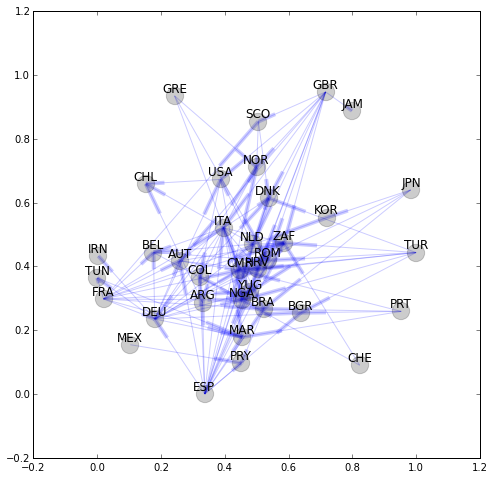

In [34]:
import networkx

G = networkx.DiGraph(football)

f = open("football_nodename.txt")
m = list(f)
f.close()

def rename(x): return m[x]

G = networkx.relabel_nodes(G, rename, copy=True)
pos = networkx.spring_layout(G)  

plt.figure(figsize=(8,8))
networkx.draw_networkx(G, pos, alpha=0.2, node_color='k', edge_color='b')
plt.show()

The module scipy.sparse borrows from numpy some interesting concepts to create constructors and special matrices:

<table>
<tr><td> `scipy.sparse.diags(diagonals, offsets)` </td><td>
Sparse matrix from diagonals </td></tr>
<tr><td> `scipy.sparse.rand(m, n, density)` </td><td>
Random sparse matrix of prescribed density </td></tr>
<tr><td> `scipy.sparse.eye(m)` </td><td>
Sparse matrix with ones in main diagonal </td></tr>
<tr><td> `scipy.sparse.identity(n)` </td><td>
Identity sparse matrix of size n-by-n </td></tr>
</table>

Both functions `diags` and `rand` deserve examples to show their syntax.  We will start with a sparse matrix of size 14-by-14 with two diagonals: the main diagonal contains 1's, and the diagonal below contains 2's.  We also create a random matrix with the function `scipy.sparse.rand`. This matrix has size 5-by-5, with 25% non-zero elements (`density=0.25`), and is crafted in `LIL` format.

In [35]:
diagonals = [[1]*14, [2]*13]

print spsp.diags(diagonals, [0,-1]).todense()

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.]]


In [36]:
S_25_lil = spsp.rand(5, 5, density=0.25, format='lil')  
S_25_lil

<5x5 sparse matrix of type '<type 'numpy.float64'>'
	with 6 stored elements in LInked List format>

In [37]:
print S_25_lil

  (0, 0)	0.0111223724518
  (1, 2)	0.217114963119
  (1, 3)	0.61783197513
  (2, 1)	0.679989949913
  (3, 4)	0.279148376412
  (4, 4)	0.537101133573


In [38]:
print S_25_lil.todense()

[[ 0.011  0.     0.     0.     0.   ]
 [ 0.     0.     0.217  0.618  0.   ]
 [ 0.     0.68   0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.279]
 [ 0.     0.     0.     0.     0.537]]


In a similar fashion to the way we combined `ndarray` instances, we have some clever ways to combine sparse matrices to construct more complex objects:

<table>
<tr><td> `scipy.sparse.bmat(blocks)` </td><td>
Sparse matrix from sparse sub-blocks </td></tr>
<tr><td> `scipy.sparse.hstack(blocks)` </td><td>
Stack sparse matrices horizontally </td></tr>
<tr><td> `scipy.sparse.vstack(blocks)` </td><td>
Stack sparse matrices vertically </td></tr>
</table>

### Linear Operators

<table>
<tr><td> `scipy.sparse.linalg.LinearOperator(shape, matvec)` </td><td>
Common interface for performing matrix vector products </td></tr>
<tr><td> `scipy.sparse.linalg.aslinearoperator(A)` </td><td>
Return A as a LinearOperator </td></tr>
</table>

A linear operator is basically a function that takes as input a column vector and outputs another column vector, by left multiplication of the input with a matrix.  Although technically we could represent these objects just by handling the corresponding  matrix, there are better ways to do so.  

In the module `scipy.sparse.linalg` we have a common interface that handles these objects: the class `LinearOperator`.  This class has only two attributes and three methods:
* `shape`, the shape of the representing matrix.
* `dtype`, the data type of the matrix.
* `matvec`, to perform multiplication of a matrix with a vector. 
* `rmatvec`, to perform multiplication by the conjugate transpose of a matrix with a vector. 
* `matmat`, to perform multiplication of a matrix with another matrix.  

Its usage is best explained through an example.  Consider two functions that take vectors of size 3, and output vectors of size 4, by left multiplication with two respective matrices of size 4-by-3.  We could very well define these functions with `lambda` predicates:

In [39]:
H1 = np.matrix("1,3,5; 2,4,6; 6,4,2; 5,3,1")
H2 = np.matrix("1,2,3; 1,3,2; 2,1,3; 2,3,1") 

def L1(x): return H1.dot(x)
def L2(x): return H2.dot(x)

print L1(np.ones(3))

[[  9.  12.  12.   9.]]


In [40]:
print L2(np.tri(3,3))

[[ 6.  5.  3.]
 [ 6.  5.  2.]
 [ 6.  4.  3.]
 [ 6.  4.  1.]]


Now one issue arises when we try to add/subtract these two functions, or multiply any of them by a scalar.  Technically it should be as easy as adding/subtracting the corresponding matrices, or multiplying them by any number, and then performing the required left multiplication again.  But that is not the case.

For instance, we would like to write `(L1+L2)(v)` instead of `L1(v) + L2(v)`.   Unfortunately, doing so will raise an error:

In [41]:
L1 + L2

TypeError: unsupported operand type(s) for +: 'function' and 'function'

Instead, we may instantiate the corresponding linear operators, and manipulate them at will, as follows:

In [42]:
Lo1 = spspla.aslinearoperator(H1)
Lo2 = spspla.aslinearoperator(H2)

Lo1 - 6 * Lo2

<4x3 _SumLinearOperator with dtype=int64>

In [43]:
print Lo1 * np.ones(3)

[  9.  12.  12.   9.]


In [44]:
print (Lo1-6*Lo2) * np.tri(3,3)

[[-27. -22. -13.]
 [-24. -20.  -6.]
 [-24. -18. -16.]
 [-27. -20.  -5.]]


Linear operators are a great advantage when the amount of information needed to describe the product with the related matrix is less than the amount of memory needed to store the non-zero elements of the matrix.

For instance, a **permutation matrix** is a square binary matrix (ones and zeros) that has exactly one entry 1 in each row and each column.  Consider a large permutation matrix, say 1024-by-1024, formed by four blocks of size 512-by-512: a zero block followed horizontally by an identity block, on top of an identity block followed horizontally by another zero block.  We may store this matrix in three different ways:

In [45]:
P_sparse = spsp.diags([[1]*512, [1]*512], [512,-512], dtype=int)

P_dense = P_sparse.todense()

def mv(v): return np.roll(v, len(v)/2)

P_lo = spspla.LinearOperator((1024,1024), matvec=mv, matmat=mv, dtype=int) 

In the sparse case, `P_sparse`, we may think of this as the storage of just 1024 integer numbers.  In the dense case, `P_dense`, we are technically storing 1048576 integer values.  In the case of the linear operator, it actually looks like we are not  storing anything!  The function `mv` that indicates how to perform the multiplications has a much smaller footprint than any of the related matrices.  This is also reflected in the time of execution of the multiplications with these objects:

In [46]:
%timeit P_sparse * np.ones(1024)

The slowest run took 18.47 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.5 µs per loop


In [47]:
%timeit P_dense.dot(np.ones(1024))

100 loops, best of 3: 2.53 ms per loop


In [48]:
%timeit P_lo * np.ones(1024)

The slowest run took 10.58 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 14.9 µs per loop


## Basic matrix manipulation

The emphasis of the second part of this chapter is on mastering the following operations:
* Scalar multiplication, matrix addition and matrix multiplication
* Traces and Determinants
* Transposes and Inverses
* Norms and Condition Numbers

### Scalar multiplication, matrix addition and matrix multiplication

Let us start with matrices stored with the `ndarray` class. We accomplish scalar multiplication with the `*` operator, and matrix addition with the `+` operator. But for matrix multiplication we need the instance method `dot()`, or the `numpy.dot` function, since the `*` operator is reserved for element-wise multiplication.

In [49]:
2*A

array([[ 2,  4],
       [ 8, 32]])

In [50]:
A + 2*A

array([[ 3,  6],
       [12, 48]])

In [51]:
A.dot(2*A)

array([[ 18,  68],
       [136, 528]])

In [52]:
np.dot(A, 2*A)

array([[ 18,  68],
       [136, 528]])

In [53]:
A.dot(B)

ValueError: shapes (2,2) and (3,2) not aligned: 2 (dim 1) != 3 (dim 0)

In [54]:
B.dot(A)

array([[ -9, -34],
       [  0,   0],
       [  9,  34]])

In [55]:
np.dot(B, A)

array([[ -9, -34],
       [  0,   0],
       [  9,  34]])

The `matrix` class makes matrix multiplication more intuitive: the operator `*` can be used instead of the `dot()` method. Note also how matrix multiplication between different instance classes `ndarray` and a matrix is always casted to a `matrix` instance class:

In [56]:
C * B

ValueError: shapes (2,2) and (3,2) not aligned: 2 (dim 1) != 3 (dim 0)

In [57]:
B * C

matrix([[ -9, -34],
        [  0,   0],
        [  9,  34]])

For sparse matrices, both scalar multiplication and addition work well with the obvious operators, even if the two sparse classes are not the same. Note the resulting class casting after each operation:

In [58]:
S_10_coo = spsp.rand(5, 5, density=0.1, format='coo')

S_25_lil + S_10_coo

<5x5 sparse matrix of type '<type 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [59]:
S_25_lil * S_10_coo

<5x5 sparse matrix of type '<type 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

`numpy.dot` does not work well for matrix multiplication of a sparse matrix with a generic.  We must use the operator `*` instead.

In [60]:
S_100_coo = spsp.rand(2, 2, density=1, format='coo')

np.dot(A, S_100_coo) 

//anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:235: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  " != instead.", SparseEfficiencyWarning)


array([[ <2x2 sparse matrix of type '<type 'numpy.float64'>'
	with 4 stored elements in COOrdinate format>,
        <2x2 sparse matrix of type '<type 'numpy.float64'>'
	with 4 stored elements in COOrdinate format>],
       [ <2x2 sparse matrix of type '<type 'numpy.float64'>'
	with 4 stored elements in COOrdinate format>,
        <2x2 sparse matrix of type '<type 'numpy.float64'>'
	with 4 stored elements in COOrdinate format>]], dtype=object)

In [61]:
A * S_100_coo

array([[  1.263,   2.741],
       [  9.583,  18.157]])

### Traces and Determinants

The traces of a matrix are the sums of the elements on the diagonals (assuming always increasing indices in both dimensions).  For generic matrices, we compute them with the instance method `trace()`, or with the function `numpy.trace`:

In [62]:
A.trace()

17

In [63]:
C.trace()

matrix([[17]])

In [64]:
B.trace()

-1

In [65]:
np.trace(B, offset=-1)

2

In order to compute the determinant of generic square matrices, we need the function `det` in the module `scipy.linalg`.

In [66]:
spla.det(C)

8.0

### Transposes and Inverses

Transposes can be computed with any of the two instance methods `transpose()` or `T`, for any of the two classes of generic matrices.

In [67]:
B.transpose()

array([[-1,  0,  1],
       [-2,  0,  2]])

In [68]:
C.T

matrix([[ 1,  4],
        [ 2, 16]])

Hermitian transposes can be computed for the matrix class with the instance method `H`.

In [69]:
D = C * np.diag((1j,4))
print D

[[  0.+1.j   8.+0.j]
 [  0.+4.j  64.+0.j]]


In [70]:
print D.H

[[  0.-1.j   0.-4.j]
 [  8.-0.j  64.-0.j]]


Inverses of non-singular square matrices are computed for the `ndarray` class with the function `inv` in the module `scipy.linalg`. For the `matrix` class, we may also use the instance method `I`. For non-singular square sparse matrices, we may use the function `inv` in the module `scipy.sparse.linalg`.

Inverses of sparse matrices are seldom sparse.  For this reason, it is not recommended to perform this operation with the `scipy.sparse.inv` function.  One possible way to go around this issue is to convert the matrix to generic with the `todense()` instance method, and use `scipy.linear.inv` instead.

But due to the difficulty of inverting large matrices, it is often beneficial to compute approximations to the inverse, instead.  The function `spilu` in the module `scipy.sparse.linalg` provides us with a very fast algorithm to perform this computation for square sparse matrices in `CSC` format.  This algorithm is based on `LU` decompositions, and coded internally as a wrapper of a function from the library `SuperLU`.  Its use is rather complex, and we are going to postpone its study until we explore matrix factorizations.

In [71]:
E = spsp.rand(512, 512, density=1).todense()

S_100_csc = spsp.rand(512, 512, density=1, format='csc')

%timeit E.I

100 loops, best of 3: 6.12 ms per loop


In [72]:
%timeit spspla.inv(S_100_csc)

1 loops, best of 3: 857 ms per loop


>In the execution of sparse inverses, if the input matrix is not in `CSC` or `CSR` formats, we will get a warning:

In [73]:
spspla.inv(S_100_coo)

//anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:90: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
//anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:157: SparseEfficiencyWarning: spsolve requires sparse b be in CSC or CSR matrix format
  SparseEfficiencyWarning)


<2x2 sparse matrix of type '<type 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Column format>

The **Moore-Penrose pseudo-inverse** can be computed for any kind of matrix (not necessarily square) with either routines `pinv` or `pinv2` in the module scipy.linalg.  The first method, `pinv`, resorts to solving a least-squares problem to compute the pseudo-inverse.  The function `pinv2` computes the pseudo-inverse by a method based on singular value decompositions.  For hermitian matrices, or matrices which are symmetric with no complex coefficients, we also have a third function `pinvh` based on eigenvalue decompositions.

It is known that in case of square non-singular matrices, the inverse and pseudo-inverse are the same.  This simple example shows times of computation of inverses of a large generic symmetric matrix with the five methods described:

In [74]:
F = E + E.T     # F is symmetric

%timeit F.I

100 loops, best of 3: 5.98 ms per loop


In [75]:
%timeit spla.inv(F)

100 loops, best of 3: 5.95 ms per loop


In [76]:
%timeit spla.pinvh(E)

10 loops, best of 3: 53.6 ms per loop


In [77]:
%timeit spla.pinv2(E)

10 loops, best of 3: 102 ms per loop


In [78]:
%timeit spla.pinv(F)

1 loops, best of 3: 2.05 s per loop


### Norms and Condition Numbers

For generic matrices, we have seven different standard norms in `scipy.linalg`.  We summarize them in the following table:

<table>
<tr><td> `norm(A,numpy.inf)` </td><td>
Sum absolute values of entries on each row. Pick the largest value </td></tr>
<tr><td> `norm(A,-numpy.inf)` </td><td>
Sum absolute values of entries on each row. Pick the smallest value </td></tr>
<tr><td> `norm(A,1)` </td><td>
Sum absolute values of entries on each column.  Pick the largest value </td></tr>
<tr><td> `norm(A,-1)` </td><td>
Sum absolute values of entries on each column. Pick the smallest value </td></tr>
<tr><td> `norm(A,2)` </td><td>
Largest eigenvalue of the matrix </td></tr>
<tr><td> `norm(A,-2)` </td><td>
Smallest eigenvalue of the matrix </td></tr>
<tr><td> `norm(A,'fro') or norm(A,'f')` </td><td>
Frobenius norm: the square-root of the trace of the product $A^H \cdot A$ </td></tr>
</table>

In [79]:
[spla.norm(A,s) for s in (np.inf,-np.inf,-1,1,-2,2,'fro')]

[20, 3, 5, 18, 0.48087417361008861, 16.636368595013604, 16.643316977093239]

>For sparse matrices, we can always compute norms by applying the `todense()` instance method prior to computation. But when the sizes of the matrices are too large, this is very impractical. In those cases, the best we can get for the 1-norm is a lower bound, thanks to the function `onenormest` in the module `scipy.sparse.linalg`

In [80]:
spla.norm(S_100_csc.todense(), 1) - spspla.onenormest(S_100_csc)

-5.6843418860808015e-14

>As for the 2-norms, we may find the values of the smallest and largest eigenvalue, but only for square matrices.  We have two algorithms in the module `scipy.sparse.linalg` that perform this task: `eigs` (for generic square matrices), and `eigsh` for real symmetric matrices.  We will explore them in detail when we discuss matrix decompositions.

Note the subtle difference between the norm computations from `scipy` and `numpy`:  For example, in the case of the Frobenius norm, `scipy.linalg.norm` is based directly on the `BLAS` function `NRM2`, while `numpy.linalg.norm` is equivalent to a purely straightforward computation of the form `sqrt(add.reduce((x.conj() * x).real))`.  The advantage of the code based on `BLAS`, besides being much faster, is clear when some of the data is too large or too small in single precision arithmetic, as the following example shows:

In [81]:
a = np.float64([1e20])
b = np.float32([1e20])

[np.linalg.norm(a), spla.norm(a)]

[1e+20, 1e+20]

In [82]:
np.linalg.norm(b)

inf

In [83]:
spla.norm(b)

1.0000000200408773e+20

This brings us inevitably to a discussion about the computation of the condition number of a non-singular square matrix $A$.  This value measures how much will change the output of the solution to the linear equation $A \cdot x = b$ when we perform small changes in the input argument $b$.  If this value is close to one, we can rest assured that the solution is going to change very little (we say then that the system is well-conditioned).  If the condition number is large, we know that there might be issues with the computed solutions of the system (and we say then that it is ill-conditioned).

The computation of this condition number is performed by multiplying the norm of $A$, with the norm of its inverse.   Note that there are different condition numbers, depending on the norm we choose for the computation.  These values can also be computed for each of the pre-defined norms with the function `numpy.linalg.cond`, although we need to be aware of its obvious limitations.

In [84]:
np.linalg.cond(C, -np.inf)

1.875

### Matrix Functions

<table>
<tr><td> `scipy.linalg.funm(A, func, disp)` </td><td>
Extension of a scalar-valued function func to a matrix </td></tr>
<tr><td> `scipy.linalg.fractional_matrix_power(A, t)` </td><td>
Fractional matrix power </td></tr>
<tr><td> `scipy.linalg.expm(A) or scipy.sparse.linalg.expm(A)` </td><td>
Matrix exponential </td></tr>
<tr><td> `scipy.sparse.linalg.expm_multiply(A,B)` </td><td>
Action of the matrix exponential of `A` on `B` </td></tr>
<tr><td> `scipy.linalg.expm_frechet(A, E)` </td><td>
Frechet derivative of the matrix exponential in the direction `E` </td></tr>
<tr><td> `scipy.linalg.cosm(A)` </td><td>
Matrix cosine </td></tr>
<tr><td> `scipy.linalg.sinm(A)` </td><td>
Matrix sine </td></tr>
<tr><td> `scipy.linalg.tanm(A)` </td><td>
Matrix tangent </td></tr>
<tr><td> `scipy.linalg.coshm(A)` </td><td>
Hyperbolic matrix cosine </td></tr>
<tr><td> `scipy.linalg.sinhm(A)` </td><td>
Hyperbolic matrix sine </td></tr>
<tr><td> `scipy.linalg.tanhm(A)` </td><td>
Hyperbolic matrix tangent </td></tr>
<tr><td> `scipy.linalg.signm(A)` </td><td>
Matrix sign function </td></tr>
<tr><td> `scipy.linalg.sqrtm(A, disp, blocksize)` </td><td>
Matrix square root </td></tr>
<tr><td> `scipy.linalg.logm(A, disp)` </td><td>
Matrix logarithm </td></tr>
</table>

A matrix function is a function that maps a square matrix to another square matrix via power series.  These should not be confused with vectorizations: the application of any given function of one variable to each element of a matrix.  For example, it is not the same to compute the square of a square matrix, `A.dot(A)` (example `In [8]`), than a matrix with all the elements of `A` squared (examples `In [5]` through `In [7]`).  

>To make the proper distinction in notation, we will write `A^2` to denote the actual square of a square matrix, and `A^n` subsequent powers (for all positive integers `n`).

In [85]:
def square(x): return x**2

A = spla.hilbert(4)
print A

[[ 1.     0.5    0.333  0.25 ]
 [ 0.5    0.333  0.25   0.2  ]
 [ 0.333  0.25   0.2    0.167]
 [ 0.25   0.2    0.167  0.143]]


In [86]:
print square(A)

[[ 1.     0.25   0.111  0.062]
 [ 0.25   0.111  0.062  0.04 ]
 [ 0.111  0.062  0.04   0.028]
 [ 0.062  0.04   0.028  0.02 ]]


In [87]:
print A*A 

[[ 1.     0.25   0.111  0.062]
 [ 0.25   0.111  0.062  0.04 ]
 [ 0.111  0.062  0.04   0.028]
 [ 0.062  0.04   0.028  0.02 ]]


In [88]:
print A**2

[[ 1.     0.25   0.111  0.062]
 [ 0.25   0.111  0.062  0.04 ]
 [ 0.111  0.062  0.04   0.028]
 [ 0.062  0.04   0.028  0.02 ]]


In [89]:
print A.dot(A)

[[ 1.424  0.8    0.567  0.441]
 [ 0.8    0.464  0.333  0.262]
 [ 0.567  0.333  0.241  0.19 ]
 [ 0.441  0.262  0.19   0.151]]


The actual powers `A^n` of a matrix is the starting point for the definition of any matrix function.   In the module `numpy.linalg` we have the routine `matrix_power` to perform this operation.  We can also achieve this result with the generic function `funm`, or with the function `fractional_matrix_power`, both of them in the module `scipy.linalg`.

In [90]:
print np.linalg.matrix_power(A, 2)

[[ 1.424  0.8    0.567  0.441]
 [ 0.8    0.464  0.333  0.262]
 [ 0.567  0.333  0.241  0.19 ]
 [ 0.441  0.262  0.19   0.151]]


In [91]:
print spla.fractional_matrix_power(A, 2)

[[ 1.424  0.8    0.567  0.441]
 [ 0.8    0.464  0.333  0.262]
 [ 0.567  0.333  0.241  0.19 ]
 [ 0.441  0.262  0.19   0.151]]


In [92]:
print spla.funm(A, square)

[[ 1.424  0.8    0.567  0.441]
 [ 0.8    0.464  0.333  0.262]
 [ 0.567  0.333  0.241  0.19 ]
 [ 0.441  0.262  0.19   0.151]]


To compute any matrix function, theoretically we first express the function as a power series, by means of its Taylor expansion.  Then we apply the input matrix into an approximation to that expansion (since it is impossible to add matrices ad infinitum).   Most matrix functions necessarily carry an error of computation, for this reason. In the module `scipy.linalg` we have the following matrix functions computed with this idea (but not necessarily with this algorithm!).

Note that there are three functions with an optional Boolean parameter `disp`.  To understand the usage of this parameter, we must remember that most matrix functions compute approximations, with an error of computation.  The parameter `disp` is set to `True` by default, and it produces a warning if the error of approximation is large.  If we set `disp` to `False`, instead of a warning we will obtain the 1-norm of the estimated error.

The algorithms behind the functions `expm`, the action of an exponential over a matrix, `expm_multiply`, and the Frechet derivative of an exponential, `expm_frechet`, use Pade approximations instead of Taylor expansions.  This allows more robust and accurate calculations.  All the trigonometric and hyperbolic trigonometric functions base their algorithm in easy computations involving `expm`.

The generic matrix function `funm` and the square-root function `sqrtm` apply clever algorithms that play with the Schur decomposition of the input matrix, and proper algebraic manipulations with the corresponding eigenvalues.  They are still prone to roundoff errors, but much faster and accurate than any algorithm based on Taylor expansions.

The matrix sign function `signm` is initially an application of `funm` with the appropriate function but, should this approach fail, the algorithm takes a different approach based on iterations that converges to a decent approximation to the solution.

The functions `logm` and `fractional_matrix_power` (when the latter is applied to non-integer powers) both use a very complex combination (and improvement!) of Pade approximations and Schur decompositions.  

>We will explore Schur decompositions when we deal with matrix factorizations related to eigenvalues.  In the meantime, if interested in learning the particular of these clever algorithms, read their descriptions in Golub and Van Loan, *Matrix Computations* 4 ed., Johns Hopkins Studies in the Mathematical Sciences, vol.3.

>For details on the improvements to Schur-Pade algorithms, as well as the algorithm behind Frechet derivatives of the exponential, refer to:
* Nicholas J. Higham and Lijing Lin *An Improved Schur-Pade Algorithm for Fractional Powers of a matrix and their Frechet derivatives*
* Awad H. Al-Mohy and Nicholas J. Higham *Improved Inverse Scaling and Squaring Algorithms for the Matrix Logarithm*, in SIAM Journal on Scientific Computing, 34 (4).

## Matrix Factorizations related to solving matrix equations

The concept of **matrix decompositions** is what makes Numerical Linear Algebra an efficient tool in Scientific Computing: If the matrix representing a problem is simple enough, any basic generic algorithm can find the solutions optimally (that is: fast, with minimal storage of data, and without significant roundoff error).  But in real life this situation seldom occurs.  What we do in the general case is to find a suitable matrix factorization, and tailor an algorithm that is optimal on each factor, thus gaining on each step obvious advantage.  In this section we explore the different factorizations included in the modules `scipy.linalg` and `scipy.sparse.linalg` that help us achieve robust solution to matrix equations.

### Relevant Factorizations

We have the following factorizations in this category:

#### Pivoted LU decomposition

It is always possible to perform a factorization of a square matrix $A$ as a product $A = P \cdot L \cdot U$ of a permutation matrix $P$ (which performs a permutation of the rows of $A$), a lower triangular matrix $L$, and an upper triangular matrix $U$: 

<table>
<tr><td> `scipy.linalg.lu(A)` </td><td>
Pivoted LU decomposition </td></tr>
<tr><td> `scipy.linalg.lu_factor(A)` </td><td>
Pivoted LU decompositions </td></tr>
<tr><td> `scipy.sparse.linalg.splu(A)` </td><td>
Pivoted LU decomposition </td></tr>
<tr><td> `scipy.sparse.linalg.spilu(A)` </td><td>
Incomplete Pivoted LU decomposition </td></tr>
</table>

#### Cholesky decomposition

For a square, symmetric and positive definite matrix $A$, we can realize the matrix as the product $A = U^T \cdot U$ of an upper triangular matrix $U$ with its transpose, or as the product $A = L^T \cdot L$ of a lower triangular matrix $L$ with its transpose.  All the diagonal entries of $U$ or $L$ are strictly positive numbers.

<table>
<tr><td> `scipy.linalg.cholesky(A)` </td><td>
Cholesky decomposition </td></tr>
<tr><td> `scipy.linalg.cholesky_banded(AB)` </td><td>
Cholesky decomposition for Hermitian positive-definite banded matrices </td></tr>
</table>


#### QR decomposition

We can realize any matrix of size m-by-n as the product $A=Q \cdot R$ of a square orthogonal matrix $Q$ of size m-by-m, with an upper triangular matrix $R$ of the same size as $A$.

<table>
<tr><td> `scipy.linalg.qr(A)` </td><td> QR decomposition of a matrix </td></tr>
</table>

#### Singular Value decomposition
We can realize any matrix $A$ as the product $A = U \cdot D \cdot V^H$ of a unitary matrix $U$ with a diagonal matrix $D$ (where all entries in the diagonal are positive numbers), and the Hermitian transpose of another unitary matrix $V$.  The values on the diagonal of $D$ are called the singular values of $A$.

<table>
<tr><td> `scipy.linalg.svd(A)` </td><td>
SVD decomposition </td></tr>
<tr><td> `scipy.linalg.svdvals(A)` </td><td>
Singular values </td></tr>
<tr><td> `scipy.linalg.diagsvd(s, m, n)` </td><td>
Diagonal matrix of an SVD, from singular values `s` and prescribed size </td></tr>
<tr><td> `scipy.sparse.linalg.svds(A)` </td><td>
Largest k singular values/vectors of a sparse matrix </td></tr>
</table>

## Matrix Equations  

In `scipy` we have robust algorithms to solve any matrix equation based on the following cases:
* Given a square matrix $A$, and a right-hand side $b$ (which can be a one-dimensional vector, or another matrix with the same number of rows as $A$), any of the basic systems 
    * $A \cdot x = b$
    * $A^T \cdot x = b$
    * $A^H \cdot x = b$
* Given any matrix $A$ (not necessarily square) and right-hand side vector/matrix $b$ of appropriate size, the least squares solution to the equation $A \cdot x = b$.  This is, finding a vector $x$ that minimizes the Frobenius norm of the expression $A \cdot x - b$.
* For the same case as before, and an extra damping coefficient $d$, the regularized least squares solution to the equation $A \cdot x = b$ that minimizes the functional 
$$ \lVert A \cdot x - b\rVert^2_2 + d^2 \lVert x\rVert^2_2.$$
* Given square matrices $A$, $B$ and a right-hand side matrix $Q$ with appropriate sizes, the Sylvester system $A \cdot X + X \cdot B = Q$.
* For a square matrix $A$ and matrix $Q$ of appropriate size, the Continuous Lyapunov equation $A \cdot X + X \cdot A^H = Q$.
* For matrices $A$ and $Q$ as in the previous case, the Discrete Lyapunov equation $X - A \cdot X \cdot A^H = Q$.
* Given square matrices $A$, $Q$, $R$ and another matrix $B$ with appropriate size, the Continuous Algebraic Riccati equation 
$A^T \cdot X + X \cdot A - X \cdot B \cdot R^{-1} \cdot B^T \cdot X + Q = 0$.
* For matrices as in the previous case, the Discrete Algebraic Riccati equation 
$X = A^T \cdot X \cdot A - \big( A^T \cdot X \cdot B \big) \cdot \big( R + B^T \cdot X \cdot B \big)^{-1}  \cdot \big( B^T \cdot X \cdot A \big) + Q$.

In any case, mastering matrix equations with `scipy` basically means identifying the matrices involved, and choosing the most adequate algorithm in the libraries to perform the requested operations.  Besides being able to compute a solution with the least possible amount of roundoff error, we need to do so in the fastest possible way, and using as little memory resources as possible.

### Back and Forward Substitution

Let us start with the easiest possible case: The basic system of linear equations $A \cdot x = b$ (or the other two variants), where $A$ is a generic lower or upper triangular square matrix. In theory, these systems are easily solved by forward substitution (for lower triangular matrices) or back substitution (for upper).  In `scipy`, we accomplish this task with the function `solve_triangular` in the module `scipy.linalg`.

For this initial example, we will construct $A$ as a lower triangular Pascal matrix of size 1024-by-1024, where the non-zero values have been filtered: odd values are turned to ones, while even values are turned to zeros.  The right-hand side $b$ is a vector with 1024 ones.

In [93]:
A = (spla.pascal(1024, kind='lower')%2 != 0)

%timeit spla.solve_triangular(A, np.ones(1024))

100 loops, best of 3: 2.76 ms per loop


To solve the other related systems that involve the matrix $A$, we employ the optional parameter `trans` (by default set to 0 or `N`, giving the basic system $A \cdot x = b$).  If `trans` is set to `T` or 1, we solve the system $A^T \cdot x = b$ instead.   If `trans` is set to `C` or 2, we solve $A^H \cdot x = b$ instead.

>The function `solve_triangular` is a wrapper for the `LAPACK` function `TRTRS`.

### Basic Systems: Banded Matrices

The next cases in terms of algorithm simplicity are those of basic systems $A \cdot x = b$ where $A$ is a square banded matrix.  We use the routines `solve_banded` (for a generic banded matrix) or `solveh_banded` (for a generic real symmetric of complex Hermitian banded matrix). Both of them belong to the module `scipy.linalg`.

>The functions `solve_banded` and `solveh_banded` are wrappers for the `LAPACK` functions `GBSV`, and `PBSV`, respectively.

Neither function accepts a matrix in the usual format.  For example, since `solveh_banded` expects a symmetric banded matrix, the function requires as input only the elements of the diagonals on and under/over the main diagonal, stored sequentially from top to bottom.

This input method is best explained through a concrete example.  Take the following symmetric banded matrix:

$$\begin{pmatrix}
2& -1&  0&  0&  0&  0\\
-1&  2& -1&  0&  0&  0\\
 0& -1&  2& -1&  0&  0\\
 0&  0& -1&  2& -1&  0\\
 0&  0&  0& -1&  2& -1\\
 0&  0&  0&  0& -1&  2
\end{pmatrix}$$

The size of the matrix is 6-by-6, and there are only 3 non-zero diagonals, two of which are identical due to symmetry.  We collect the two relevant non-zero diagonals in an ndarray of size 2-by-6 in one of two ways, as follows:
* If we decide to input the entries from the upper triangular matrix, we collect first the diagonals from top to bottom (ending in the main diagonal), right justified: 

        X -1 -1 -1 -1 -1
        2  2  2  2  2  2
    
* If we decide to input the entries from the lower triangular matrix, we collect the diagonals from top to bottom (starting from the main diagonal), left justified: 

         2  2  2  2  2  2   
        -1 -1 -1 -1 -1  X

In [94]:
B_banded = np.zeros((2,6))
B_banded[0,1:] = -1
B_banded[1,:] = 2

spla.solveh_banded(B_banded, np.ones(6))

array([ 3.,  5.,  6.,  6.,  5.,  3.])

For a non-symmetric banded square matrix, we use `solve_banded` instead, and the input matrix also needs to be stored in this special way:
* Count the number of non-zero diagonals under the main diagonal (set that to $\ell$).  Count the number of non-zero diagonals over the main diagonal (set that to $u$).  Set $r = \ell + u + 1$.
* If the matrix has size n-by-n, create an ndarray with n columns, and r rows.  We refer to this storage as a matrix in AB form, or an AB matrix, for short.
* Store in the AB matrix only the relevant non-zero diagonals, from top to bottom, in order.  Diagonals over the main diagonal are right justified; diagonals under the main diagonal are left justified.
Let us illustrate this process with another example.  We input the following matrix:

$$\begin{pmatrix}
2& -1&  0&  0&  0&  0\\
-1&  2& -1&  0&  0&  0\\
 3& -1&  2& -1&  0&  0\\
 0&  3& -1&  2& -1&  0\\
 0&  0&  3& -1&  2& -1\\
 0&  0&  0&  3& -1&  2
\end{pmatrix}$$

In [95]:
C_banded = np.zeros((4,6))
C_banded[0,1:] = -1
C_banded[1,:] = 2
C_banded[2,:-1] = -1
C_banded[3,:-2] = 3

print C_banded

[[ 0. -1. -1. -1. -1. -1.]
 [ 2.  2.  2.  2.  2.  2.]
 [-1. -1. -1. -1. -1.  0.]
 [ 3.  3.  3.  3.  0.  0.]]


To call the solver, we need to input manually the number of diagonals over and under the diagonal, together with the AB matrix and the right-hand side of the system:

In [96]:
spla.solve_banded((2,1), C_banded, np.ones(6))

array([ 0.868,  0.737, -0.395,  0.079,  1.763,  1.263])

Let us examine the optional parameters that we can include in the call of these two functions:

<table>
<tr><td> `l_and_u` </td><td> `(int, int)` </td><td>
Number of non-zero lower/upper diagonals </td></tr>
<tr><td> `AB` </td><td> Matrix in AB format </td><td>
A banded square matrix </td></tr>
<tr><td> `b` </td><td> `ndarray` </td><td>
Right-hand side </td></tr>
<tr><td> `overwrite_ab` </td><td> `Boolean` </td><td>
Discard data in AB </td></tr>
<tr><td> `overwrite_b` </td><td> `Boolean` </td><td>
Discard data in b </td></tr>
<tr><td> `check_finite` </td><td> `Boolean` </td><td>
Whether to check that input matrices contain finite numbers </td></tr>
</table>

>All the functions in the module `scipy.linalg` that require matrices as input, and output either a solution to a system of equations, or a factorization, have two optional parameters with which we need to familiarize: `overwrite_x` (for each matrix/vector in the input) and `check_finite`.  They are both Boolean.  

>The `overwrite` options are set to `False` by default.  If we do not care about retaining the values of the input matrices, we may use the same object in memory to perform operations, rather than creating another object with the same size in memory.  We gain speed and use fewer resources in that case.

>The `check_finite` option is set to `True` by default.  In the algorithms where present, there are optional checks for the integrity of the data.  If at a given moment any of the values is a `(+/-)numpy.inf` or a `NaN`, the process is halted, and an exception is raised.  We may turn this option off, thus resulting in much faster solutions, but the code might crash if the data is corrupted at any point in the computations.

The function `solveh_banded` has an extra optional `Boolean` parameter, `lower`, initially set to `False`.  If set to `True`, we must input the lower triangular matrix of the target AB matrix instead of the upper one (with the same input convention as before.)

#### Basic Systems: Generic Square Matrices

For solutions of basic systems where $A$ is a generic square matrix, a good idea is to factorize $A$ so that some (or all) of the factors are triangular, and then apply back and forward substitution where appropriate.  This is the idea behind pivoted LU, and Cholesky decompositions.

If the matrix $A$ is real symmetric (or complex Hermitian) and positive definite, the optimal strategy goes through applying any of the two possible Cholesky decompositions $A = U^H \cdot U$, or $A = L \cdot L^H$ with $U$ and $$L upper/lower triangular matrices.

For example, if we use the form with the upper triangular matrices, the solution of the basic system of equations $A \cdot x = b$ turns into $U^H * U * x = b$.  Set $y = U \cdot x$ and solve the system $U^H \cdot y = b$ for $y$ by forward substitution.  We have now a new triangular system $U \cdot x = y$ that we solve for $x$, by back substitution.

To perform the solution of such a system with this technique, we first compute the factorization using any of the functions `cholesky`, `cho_factor` or `cholesky_banded`.  The output is then used in the solver `cho_solve`.

For Cholesky decompositions, the three relevant functions `cholesky`, `cho_factor` and `cholesky_banded` have a set of options similar to those of `solveh_banded`.  They admit an extra `Boolean` option `lower` (set by default to `False`) that decides whether to output a lower or an upper triangular factorization.  The function `cholesky_banded` requires a matrix in AB format as input.

Let us test the Cholesky decomposition of the matrix $B$ with all three methods:

In [97]:
B = spsp.diags([[-1]*5, [2]*6, [-1]*5], [-1,0,1]).todense()
print B

[[ 2. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  2.]]


In [98]:
print spla.cholesky(B)

[[ 1.414 -0.707  0.     0.     0.     0.   ]
 [ 0.     1.225 -0.816  0.     0.     0.   ]
 [ 0.     0.     1.155 -0.866  0.     0.   ]
 [ 0.     0.     0.     1.118 -0.894  0.   ]
 [ 0.     0.     0.     0.     1.095 -0.913]
 [ 0.     0.     0.     0.     0.     1.08 ]]


In [99]:
print spla.cho_factor(B)[0]

[[ 1.414 -0.707  0.     0.     0.     0.   ]
 [-1.     1.225 -0.816  0.     0.     0.   ]
 [ 0.    -1.     1.155 -0.866  0.     0.   ]
 [ 0.     0.    -1.     1.118 -0.894  0.   ]
 [ 0.     0.     0.    -1.     1.095 -0.913]
 [ 0.     0.     0.     0.    -1.     1.08 ]]


In [100]:
print spla.cholesky_banded(B_banded)

[[ 0.    -0.707 -0.816 -0.866 -0.894 -0.913]
 [ 1.414  1.225  1.155  1.118  1.095  1.08 ]]


The output of `cho_factor` is a tuple: the second element is the `Boolean lower`.  The first element is an `ndarray` representing a square matrix.  If `lower` is set to `True`, the lower triangular sub-matrix of this `ndarray` is $L$ in the Cholesky factorization of $A$.  If `lower` is set to `False`, the upper triangular sub-matrix is $U$ in the factorization of $A$.  The remaining elements in the matrix are random, instead of zeros, since they are not used by `cho_solve`.  In a similar way, we can call `cho_solve_banded` with the output of `cho_banded` to solve the appropriate system.

>Both `cholesky` and `cho_factor` are wrappers to the same `LAPACK` function `POTRF`, with different output options. `cholesky_banded` calls `PBTRF`.  The function `cho_solve` is a wrapper for `POTRS`, and `cho_solve_banded` calls `PBTRS`.

We are then ready to solve the system, with either of the two options:

In [101]:
spla.cho_solve((spla.cholesky(B), False), np.ones(6))

array([ 3.,  5.,  6.,  6.,  5.,  3.])

In [102]:
spla.cho_solve(spla.cho_factor(B), np.ones(6))

array([ 3.,  5.,  6.,  6.,  5.,  3.])

For any other kind of generic square matrix $A$, the next-best method to solve the basic system $A \cdot x = b$ is by Pivoted LU factorization.  This is equivalent to finding a permutation matrix $P$, and triangular matrices $U$ (upper) and $L$ (lower) so that $P \cdot A = L c\cdot U$.  In that case, a permutation of the rows in the system according to $P$ gives the equivalent equation $(P \cdot A) \cdot x = P \cdot b$.  Set $c = P \cdot b$, $y = U \cdot x$, and solve for $y$ in the system $L \cdot y = c$ using forward substitution.  Then solve for $x$ in the system $U \cdot x = y$ with back substitution.

The relevant functions to perform this operation are `lu`, `lu_factor` (for factorization), and `lu_solve` (for solution) in the module `scipy.linalg`.  For sparse matrices we have `splu`, and `spilu`, in the module `scipy.sparse.linalg`.

Let us start experimenting with factorizations first.  We use a large circulant matrix (non-symmetric) for this example:

In [103]:
D = spla.circulant(np.arange(4096))
%timeit spla.lu(D)

1 loops, best of 3: 1.52 s per loop


In [104]:
%timeit spla.lu_factor(D)

1 loops, best of 3: 620 ms per loop


>The function `lu_factor` is a wrapper to all `*GETRF` routines from `LAPACK`.  The function `lu_solve` is a wrapper for `GETRS`.

The function `lu` has an extra `Boolean` option: `permute_l` (set to `False` by default).  If set to `True`, the function outputs only two matrices: $PL = P \cdot L$ (the properly permuted lower triangular matrix), and $U$.  Otherwise, the output is the triple $P, L, U$, in that order.

In [105]:
P, L, U = spla.lu(D)

PL, U = spla.lu(D, permute_l=True)

The outputs of the function `lu_factor` are resource-efficient: We obtain a matrix $LU$, with upper triangle $U$, and lower triangle $L$.  We also obtain a one-dimensional `ndarray` of integer `dtype`, `piv`, indicating the pivot indices representing the permutation matrix $P$.

In [106]:
LU, piv = spla.lu_factor(D)

The solver `lu_solve` takes the two outputs from `lu_factor`, a right-hand side $b$, and the optional indicator `trans` to the kind of basic system to solve.

In [107]:
spla.lu_solve(spla.lu_factor(D), np.ones(4096))

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

>At this point we must comment on the general function `solve` in the module `scipy.linalg`:  It is a wrapper to both `LAPACK` functions `POSV` and `GESV`.  It allows us to input the matrix $A$, right-hand side $b$, and indicate whether $A$ is symmetric and positive-definite.  In any case, the routine internally decides which of the two factorizations to use (Cholesky or Pivoted LU), and computes a solution accordingly.

For large sparse matrices, provided they are stored in `CSC` format, Pivoted LU decomposition is more efficiently performed with either functions `splu` or `spilu` from the module `scipy.sparse.linalg`. Both functions use the `SuperLU` library directly.  Their output is not a set of matrices, but a `python` object 
`scipy.sparse.linalg.dsolve._superlu.SciPyLUType`.  

This object has four attributes and one instance method:
* `shape`: A 2-tuple containing the shape of matrix $A$.
* `nnz`: The number of non-zero entries of the matrix $A$.
* `perm_c`, `perm_r`: The permutations applied to the columns and rows (respectively) to the matrix $A$ to obtain the computed LU decomposition.
* `solve`: An instance method that converts the object into a function `object.solve(b,trans)` accepting an `ndarray` $b$, and the optional description string `trans`.

The big idea is that, dealing with large amounts of data, the actual matrices in the LU decomposition are not as important as the main application behind the factorization: the solution of the system.  All the relevant information to perform this operation is optimally stored in the object's method `solve`.

The main difference between `splu` and `spilu` is that the latter computes an incomplete decomposition.  With it, we can obtain really good approximations to the inverse of the matrix $A$, and use matrix multiplication to compute the solution of large systems, in a fraction of the time it would take to calculate the actual solution.

>The usage of these two functions is rather complex: The purpose is to compute a factorization of the form $Pr \cdot Dr \cdot A \cdot Dc \cdot Pc = L \cdot U$ with diagonal matrices $Dr$ and $Dc$, and permutation matrices $Pr$ and $Pc$. The idea is to equilibrate the matrix $A$ manually, so that the product $B = Dr \cdot A \cdot Dc$ is better conditioned than $A$.  In case of the possibility of solving this problem in a parallel architecture, we are allowed to help by rearranging the rows and columns optimally.  The permutation matrices $Pr$ and $Pc$ are then manually input to pre-order the rows and columns of $B$.  All of these options can be fed to either `splu` or `spilu`.

>he algorithm exploits the idea of *relaxing supernodes* to reduce inefficient indirect addressing and symbolic time (besides permitting the use of higher level `BLAS` operations).  We are given the option to determine the degree of these objects, to tailor the algorithm to the matrix at hand.

>For a complete explanation of the algorithms and all the different options, the best reference is `SuperLU` User's Guide, which can be found online at [crd-legacy.lbl.gov/~xiaoye/SuperLU/superlu_ug.pdf](crd-legacy.lbl.gov/~xiaoye/SuperLU/superlu_ug.pdf)

Let us illustrate with a simple example, where permutation of rows or columns are not needed:  From a large lower triangular Pascal matrix, turn to zero all the even-valued entries, and to ones all the odd-valued entries.  Use this as the matrix $A$.  For the right-hand side, use a vector of ones.

In [108]:
A_csc = spsp.csc_matrix(A, dtype=np.float64)   

invA = spspla.splu(A_csc)

%time invA.solve(np.ones(1024))

CPU times: user 1.31 ms, sys: 14 µs, total: 1.33 ms
Wall time: 1.32 ms


array([ 1., -0.,  0., ..., -0., -0.,  0.])

In [109]:
invA = spspla.spilu(A_csc)

%time invA.solve(np.ones(1024))

CPU times: user 170 µs, sys: 9 µs, total: 179 µs
Wall time: 174 µs


array([ 1.,  0.,  0., ...,  0.,  0.,  0.])

>Compare the time of execution of the procedures on sparse matrices, with the initial `solve_triangular` procedure on the corresponding matrix $A$ at the beginning of the section.  Which process is faster?

But in general, if a basic system must be solved and the matrix $A$ is large and sparse, we prefer to use iterative methods with fast convergence to the actual solutions.  When they converge, they are consistently less sensitive to rounding errors, and thus more suitable when the number of computations is extremely high.

In the module `scipy.sparse.linalg`, we have eight different iterative methods, all of which accept as parameters the following:
* Matrix $A$ in any format (`matrix`, `ndarray`, sparse matrix or even a linear operator!), and right-hand side vector/matrix $b$ as an `ndarray`.
* Initial guess $x_0$, as an `ndarray`.
* Tolerance `tol`, a floating point number.  If the difference of successive iterations is less than this value, the code stops and the last computed values are output as solution.
* Maximum number of iterations allowed, `maxiter`, an integer.
* A preconditioner sparse matrix $M$ that should approximate the inverse of $A$.
* A `callback` function of the current solution vector $x_k$, called after each iteration.

<table>
<tr><td> `bicg` </td><td>
Biconjugate Gradient Iteration </td></tr>
<tr><td> `bicgstab` </td><td>
Biconjugate Gradient Stabilized Iteration </td></tr>
<tr><td> `cg` </td><td>
Conjugate Gradient Iteration </td></tr>
<tr><td> `cgs` </td><td>
Conjugate Gradient Squared Iteration </td></tr>
<tr><td> `gmres` </td><td>
Generalized Minimal Residual Iteration </td></tr>
<tr><td> `lgmres` </td><td>
LGMRES Iteration </td></tr>
<tr><td> `minres` </td><td>
Minimum Residual Iteration </td></tr>
<tr><td> `qmr` </td><td>
Quasi-minimal Residual Iteration </td></tr>
</table>

Choosing the right iterative method, a good initial guess, and especially a successful preconditioner is an art in itself.  It involves learning about topics such as operators in Functional Analysis, or Krylov subspace methods, which are far beyond the scope of this book.   At this point we are content with showing a few simple examples for comparison.

In [110]:
spspla.cg(A_csc, np.ones(1024), x0=np.zeros(1024))

(array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), 1)

In [112]:
%time spspla.gmres(A_csc, np.ones(1024), x0=np.zeros(1024))

CPU times: user 1.6 ms, sys: 620 µs, total: 2.22 ms
Wall time: 2.53 ms


(array([ 1.,  0.,  0., ..., -0., -0.,  0.]), 0)

In [113]:
Nsteps = 1

def callbackF(xk):
    global Nsteps
    print'{0:4d}  {1:3.6f}  {2:3.6f}'.format(Nsteps, xk[0], xk[1])
    Nsteps += 1
    
print '{0:4s}  {1:9s}  {1:9s}'.format('Iter', 'X[0]','X[1]')

spspla.bicg(A_csc, np.ones(1024), x0=np.zeros(1024), callback=callbackF)

Iter  X[0]       X[0]     
   1  0.017342  0.017342
   2  0.094680  0.090065
   3  0.258063  0.217858
   4  0.482973  0.328061
   5  0.705223  0.337023
   6  0.867614  0.242590
   7  0.955244  0.121250
   8  0.989338  0.040278
   9  0.998409  0.008022
  10  0.999888  0.000727
  11  1.000000  -0.000000
  12  1.000000  -0.000000
  13  1.000000  -0.000000
  14  1.000000  -0.000000
  15  1.000000  -0.000000
  16  1.000000  0.000000
  17  1.000000  0.000000


(array([ 1.,  0.,  0., ...,  0.,  0., -0.]), 0)

#### Least Squares

Given a generic matrix $A$ (not necessarily square) and a right-hand side vector/matrix $b$, we look for a vector/matrix $x$ such that the Frobenius norm of the expression $A \cdot x - b$ is minimized.  

The main three methods to solve this problem numerically are contemplated in scipy:
* Normal equations.
* QR factorization
* Singular Value Decomposition.

Normal equations reduces the least square problem to solving a basic system of linear equations, with a symmetric (not-necessarily positive-definite) matrix.  It is very fast, but can be inaccurate due to presence of roundoff error.  Basically, it amounts to solving the system $\big(A^H \cdot A\big) \cdot x = A^H \cdot b$.  This is equivalent to solving 
$x = \big(A^H \cdot A\big)^{-1} \cdot A^H \cdot b = \operatorname{pinv}(A) \cdot b$.

Let us show by example:

In [114]:
E = D[:512,:256]; b = np.ones(512)

sol1 = np.dot(spla.pinv2(E), b)

sol2 = spla.solve(np.dot(E.T, E), np.dot(E.T, b))

The QR factorization turns any matrix into the product $A = Q \cdot R$ of an orthogonal/unitary matrix $Q$ with a square upper triangular matrix $R$.  This allows us to solve without the need to invert any matrix (since $Q^H = Q^{-1}$), and thus, $A \cdot x = b$ turns into $R \cdot x = Q^H \cdot b$, easily solvable by back substitution.  Note that the two methods below are equivalent, since the mode economic reports the sub-matrices of maximum rank.

In [115]:
Q, R = spla.qr(E)
RR = R[:256, :256]
BB = np.dot(Q.T, b)[:256]

sol3 = spla.solve_triangular(RR, BB)

Q, R = spla.qr(E, mode='economic')

sol3 = spla.solve_triangular(R, np.dot(Q.T, b))

Both methods of Normal Equations and QR factorization work fast and are reliable only when the rank of $A$ is full.  If this is not the case, we must use singular value decomposition: $A = U \cdot D \cdot V^H$ with unitary matrices $U$, $V$ and a diagonal matrix $D$ where all the entries in the diagonal are positive values.  This allows a fast solution $ x = V \cdot D^{-1} \cdot U^H \cdot b$.

Note tat the two methods below are equivalent, since the option `full_matrices` set to `False` reports the sub-matrices of minimum possible size:

In [116]:
U, s, Vh = spla.svd(E)
Uh = U.T
Si = spla.diagsvd(1./s, 256, 256)
V = Vh.T

sol4 = np.dot(V, Si).dot(np.dot(Uh, b)[:256])   

U, s, Vh = spla.svd(E, full_matrices=False)
Uh = U.T
Si = spla.diagsvd(1./s, 256, 256)
V = Vh.T

sol4 = np.dot(V, Si).dot(np.dot(Uh, b))

>The module `scipy.linalg` has one function that actually performs least squares with the SVD method: `lstsq`.  There is no need to manually transpose, invert and multiply all the required matrices.  It is a wrapper to the `LAPACK` function `GELSS`.  It outputs the desired solution, together with the residues of computation, the effective rank, and the singular values of the input matrix $A$.

In [117]:
sol5, residue, rank, s = spla.lstsq(E, b)

Note how all the computations we have carried offer solutions that are very close to each other (if not equal!):

In [118]:
map(lambda x: np.allclose(sol5, x), [sol1, sol2, sol3, sol4])

[True, True, True, True]

#### Regularized Least Squares

The module `scipy.sparse.linalg` has two iterative methods for least squares in the context of large sparse matrices: `lsqr` and `lsmr`, which allow a more generalized version with a damping factor $d$ for regularization.  We seek to minimize the functional $\lVert A \cdot x - b\rVert_2^2 + d^2 \Vert x\rVert_2^2$.  

The usage and parameters are very similar to the iterative functions we studied before.

#### Other Matrix Equation Solvers

The rest of matrix equation solvers are summarized in the following table.  None of these routines enjoy any parameters to play around with performance, memory management, or check for integrity of data.

<table>
<tr><td> `solve_sylvester(A, B, Q)` </td><td>
Sylvester Equation </td></tr>
<tr><td> `solve_continuous_are(A, B, Q, R)` </td><td>
Continuous Algebraic Riccati Equation </td></tr>
<tr><td> `solve_discrete_are(A, B, Q, R)` </td><td>
Discrete Algebraic Riccati Equation </td></tr>
<tr><td> `solve_lyapunov(A, Q)` </td><td>
Continuous Lyapunov Equation </td></tr>
<tr><td> `solve_discrete_lyapunov(A, Q)` </td><td>
Discrete Lyapunov Equation </td></tr>
</table>

## Matrix Factorizations based on Eigenvalues

In this category, we have two kinds of factorizations on square matrices: Spectral and Schur decompositions (although, technically, a spectral decomposition is a special case of Schur decomposition).  The objective of both is initially to present eigenvalues of one or several matrices simultaneously, although they have quite different applications.  

### Spectral decomposition

We consider four cases:
* Given a square matrix $A$, we seek all vectors $v$ (right eigenvectors) that satisfy $A \cdot v = mv$ for some real or complex value $m$ (the corresponding eigenvalues).  If all eigenvectors are different, we collect them as the columns of a matrix $V$ (that happens to be invertible).  Their corresponding eigenvalues are stored in the same order as the diagonal entries of a diagonal matrix $D$.  We can then realize $A$ as the product $A = V \cdot D \cdot V^{-1}$.  We refer to this decomposition as an ordinary eigenvalue problem.
* Given a square matrix $A$, we seek all vectors $v$ (left eigenvectors) that satisfy $v \cdot A = mv$ for the eigenvalues $m$. As before, if all eigenvectors are different, they are collected in a matrix $V$; their corresponding eigenvalues are collected in the diagonal matrix $D$. The matrix $A$ can then be decomposed as the product $A = V \cdot D \cdot V^{-1}$.  We also refer to this factorization as an ordinary eigenvalue problem.  The eigenvalues are the same as in the previous case.
* Given square matrices $A$ and $B$ with the same size, we seek all vectors $v$ (generalized right eigenvectors) that satisfy $m \cdot A \cdot v = n \cdot B \cdot v$ for some real or complex values $m$ and $n$.  The ratios $r=n/m$, when they are computable, are called generalized eigenvalues.  The eigenvectors are collected as columns of a matrix $V$, and their corresponding generalized eigenvalues $r$ collected in a diagonal matrix $D$.  We can then realize the relation between $A$ and $B$ by the identity $A = B \cdot V \cdot D \cdot V^{-1}$. We refer to this identity as a generalized eigenvalue problem.
* For the same case as before, if we seek vectors $v$ (generalized left eigenvectors) and values $m$, $n$ that satisfy $m \cdot v \cdot A = n \cdot v \cdot B$, we have then another similar decomposition. We again refer to this factorization as a generalized eigenvalue problem.

The following functions in the modules `scipy.linalg` and `scipy.sparse.linalg` help us compute eigenvalues and eigenvectors:

<table>
<tr><td> `scipy.linear.eig(A[, B])` </td><td>
Ordinary/generalized eigenvalue problem </td></tr>
<tr><td> `scipy.linalg.eigvals(A[, B])` </td><td>
Eigenvalues for ordinary/generalized eigenvalue problem </td></tr>
<tr><td> `scipy.linalg.eigh(A[, B])` </td><td>
Ordinary/generalized eigenvalue problem. Hermitian/symmetric matrix </td></tr>
<tr><td> `scipy.linalg.eigvalsh(A[, B])` </td><td>
Eigenvalues for ordinary/generalized eigenvalue problem. Hermitian/symmetric matrix </td></tr>
<tr><td> `scipy.linalg.eig_banded(AB)` </td><td>
Ordinary eigenvalue problem Hermitian/symmetric band matrix </td></tr>
<tr><td> `scipy.linalg.eigvals_banded(AB)` </td><td>
Eigenvalues for ordinary eigenvalue problem.  Hermitian/symmetric band matrix </td></tr>
<tr><td> `scipy.sparse.linalg.eigs(A, k)` </td><td>
Find k eigenvalues and eigenvectors </td></tr> 
<tr><td> `scipy.sparse.linalg.eigsh(A, k)` </td><td>
Find k eigenvalues and eigenvectors.  Real symmetric matrix </td></tr>
<tr><td> `scipy.sparse.linalg.lobpcg(A, X)` </td><td>
Ordinary/generalized eigenvalue problem with optional preconditioning. $A$ symmetric </td></tr>
</table>

For any kind of eigenvalue problem where the matrices are not symmetric or banded, we use the function `eig`, which is a wrapper for the `LAPACK` routines `GEEV` and `GGEV` (the latter for generalized eigenvalue problems).  The function `eigvals` is syntactic sugar for a case of `eig` that only outputs the eigenvalues, but not the eigenvectors.  To report whether we require left of right eigenvectors, we use the optional Boolean parameters `left` and `right`.  By default, `left` is set to `False` and `right` to `True`, hence offering right eigenvectors.

For eigenvalue problems with non-banded real symmetric or Hermitian matrices, we use the function `eigh`, which is a wrapper for the `LAPACK` routines: `*EVR`, `*GVD`, and `*GV`. We are given the choice to output as many eigenvalues as we want, with the optional parameter `eigvals`.  This is a tuple of integers that indicate the indices of the lowest and highest eigenvalues required.  If omitted, all eigenvalues are returned.  And in that case, it is possible to perform the computation with a much faster algorithm based on divide and conquer.  We may indicate that choice with the optional Boolean parameter `turbo` (by default set to `False`).

If we desire to report only eigenvalues, we can set the optional parameter `eigvals_only` to `True`, or use instead the corresponding syntactic sugar `eighvals`.

The last case we contemplate in the `scipy.linalg` module is that of the eigenvalue problem of a banded real symmetric or Hermitian matrix.  We use then the function `eig_banded`, making sure that the input matrices are in AB format.  This function is a wrapper for the `LAPACK` routines `*EVX`.

For extremely large matrices, the computation of eigenvalues is often computationally impossible.  If these large matrices are sparse, it is possible to calculate a few eigenvalues with two iterative algorithms: the **Implicitly Restarted Arnoldi**, and the **Implicitly Restarted Lanczos** methods (the latter for symmetric or Hermitian matrices).  The module `scipy.sparse.linalg` has two functions, `eigs` and `eigsh`, which are wrappers to the `ARPACK` routines `*EUPD` that perform them.  We also have the function `lobpcg` that performs another iterative algorithm, the **Locally Optimal Block Preconditioned Conjugate Gradient Method**.  This function accepts a preconditioner, and has thus the potential to converge more rapidly to the desired eigenvalues.

We will illustrate the usage of all these functions with an interesting matrix: **Andrews**.  It was created in 2003 precisely to benchmark memory-efficient algorithms for eigenvalue problems.  It is a real symmetric sparse matrix with size 60,000-by-60,000 and 760,154 non-zero entries.  It can be downloaded from the Sparse Matrix Collection at [www.cise.ufl.edu/research/sparse/matrices/Andrews/Andrews.html](www.cise.ufl.edu/research/sparse/matrices/Andrews/Andrews.html).

For this example, we downloaded the matrix in Matrix Market format: `Andrews.mtx`.  Note that the matrix is symmetric, and the file only provide data on are below the main diagonal.  After collecting all this information, we make sure to populate the upper triangle too.

In [137]:
In [2]: np.set_printoptions(suppress=True, precision=6)
In [3]: rows, cols, data = np.loadtxt("Andrews.mtx", skiprows=14, unpack=True); rows-=1; cols-=1
In [4]: A = spsp.csc_matrix((data, (rows, cols)), shape=(60000,60000)); A = A + spsp.tril(A, k=1).transpose()

We compute first the top largest five eigenvalues in absolute value.  We call the function `eigsh`, with the option `which='LM'`.

In [138]:
In [5]: %time eigvals, v = spspla.eigsh(A, 5, which='LM')
In [6]: print eigvals

CPU times: user 1.29 s, sys: 46.2 ms, total: 1.34 s
Wall time: 1.16 s
[ 69.202683  69.645958  70.801108  70.815224  70.830983]


We may compute the smallest eigenvalues in absolute value too, by switching to the option `which='SM'`.  

In [139]:
In [7]: %time eigvals, v = spspla.eigsh(A, 5, which='SM')
In [8]: print eigvals

CPU times: user 5.92 s, sys: 178 ms, total: 6.1 s
Wall time: 5.26 s
[ 10.565523  10.663114  10.725135  10.752737  10.774503]


>The routines in `ARPACK` are not that efficient at finding small eigenvalues.  It is usually preferred to apply the **shift-invert mode** in this case for better performance.  For information about this procedure, read the description in [www.caam.rice.edu/software/ARPACK/UG/node33.html](www.caam.rice.edu/software/ARPACK/UG/node33.html) , or the article by R. B. Lehoucq, D. C. Sorensen, and C. Yang, _ARPACK USERS GUIDE: Solution of Large Scale Eigenvalue Problems by Implicitly Restarted Arnoldi Methods_. SIAM, Philadelphia, PA, 1998.

The function `eigsh` allows us to perform shift-invert mode by indicating a value close to the required eigenvalues.  If we have a good guess, as offered by the previous step, we may apply this procedure with the option `sigma`, and a strategy with the option mode.  In this case, we also need to provide a linear operator instead of a matrix.  The time of execution is much slower, but the results are much more precise in general (although the given example would not suggest so!).

In [140]:
In [9]: A = spspla.aslinearoperator(A)
In [10]: %time spspla.eigsh(A, 5, sigma=10.0, mode='cayley')
In [11]: print eigvals

CPU times: user 47.2 s, sys: 395 ms, total: 47.6 s
Wall time: 47.6 s
[ 10.565523  10.663114  10.725135  10.752737  10.774503]


### Schur decomposition

There are four cases:
* **Complex Schur decomposition** for a square matrix $A$ with complex coefficients: We can realize $A$ as the product $A = U \dot T \cdot U^H$ of a unitary matrix $U$ with an upper triangular matrix $T$, and the Hermitian transpose of $U$.  We call $T$ the complex Schur form of $A$.  The entries in the diagonal of $T$ are the eigenvalues of $A$.
* **Real Schur decomposition** for a square matrix $A$ with real coefficients.  If all the eigenvalues of the matrix are real valued, then we may realize the matrix as the product $A = V \cdot S \cdot V^T$ of an orthonormal matrix $V$ with a block-upper triangular matrix $S$, and the transpose of $V$.  The blocks in $S$ are either of size 1-by-1 or 2-by-2.  If the block is 1-by-1, the value is one of the real eigenvalues of $A$.  Any 2-by-2 block represents a pair of complex conjugate eigenvalues of $A$.  We call $S$ the real Schur form of $A$.
* **Complex Generalized Schur decomposition** of two square matrices $A$ and $B$.  We can simultaneously factorize them both in the form $A = Q \cdot S \cdot Z^H$ and $B = Q \cdot T \cdot Z^H$ with the same unitary matrices $Q$ and $Z$.  The matrices $S$ and $T$ are both upper triangular, and the ratios of their diagonal elements are precisely the generalized eigenvalues of $A$ and $B$.
* **Real Generalized Schur decomposition** of two real-valued square matrices $A$ and $B$.  Simultaneous factorization of both can be achieved in the form $A = Q \cdot S \cdot Z^T$ and $B = Q \cdot T \cdot Z^T$ for the same orthogonal matrices $Q$ and $Z$.  The matrices $S$ and $T$ are block-upper triangular, with blocks of size 1-by-1 and 2-by-2.  With the aid of these blocks, we can find the generalized eigenvalues of $A$ and $B$.

There are four functions in the module `scipy.linalg` that provide us with tools to compute any of these decompositions.

<table>
<tr><td> `scipy.linalg.schur(A)` </td><td>
Schur decomposition of a matrix </td></tr>
<tr><td> `scipy.linalg.rsf2csf(T, Z)` </td><td>
Convert real Schur form to complex Schur form </td></tr>
<tr><td> `scipy.linalg.qz(A, B)` </td><td>
Generalized Schur decomposition of two matrices </td></tr>
<tr><td> `scipy.linalg.hessenberg(A)` </td><td>
Hessenberg form of a matrix </td></tr>
</table>

The function `hessenberg` gives us the first step in the computation of any Schur decomposition.  This is a factorization of any square matrix $A$ in the form $A = Q \cdot U \cdot Q^H$, where $Q$ is unitary, and $U$ is an upper Hessenberg matrix (all entries are zero below the sub-diagonal).   The algorithm is based on the combination of the `LAPACK` routines `GEHRD`, `GEBAL` (to compute $U$), and the `BLAS` routines `GER`, `GEMM` (to compute $Q$).

The functions `schur` and `qz` are wrappers to the `LAPACK` routines `GEES` and `GGES`, to compute the normal and generalized Schur decompositions (respectively) of square matrices.  The way we choose whether to report complex or real decompositions is with the optional parameter `output` (which we set to `'real'` or `'complex'`).  We also have the possibility of sorting the eigenvalues in the matrix representation.  We do so with the optional parameter `sort`, with the following possibilities:
* `None`: If we do not require any sorting.  This is the default.
* `'lhp'`: In the left-hand plane.  
* `'rhp'`: In the right-hand plane
* `'iuc'`: Inside the unit circle
* `'ouc'`: Outside the unit circle
* `func`: Any callable function func can be used to provide the users with their own sorting.

## Summary
We have explored in this chapter the basic principles of Numerical Linear Algebra, the core of all procedures in Scientific Computing.  The emphasis was first placed in storage and basic manipulation of matrices and linear operators.  We explored in detail all different factorizations, focusing on their usage to solution of matrix equations, or eigenvalue problems.  All through the chapter, we made a point of linking the functions from the modules `scipy.linalg` and `scipy.sparse` to their corresponding routines in the libraries `BLAS`, `LAPACK`, `ARPACK` and `SuperLU`.  For our experiments, we always chose interesting matrices from real-life problems that we gathered from the extensive Sparse Matrix Collection hosted by the University of Florida.

In [84]:
from IPython.core.display import HTML

def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()